# Figure 3 plotting

In [1]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())

import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

data_folder='/nfs/team205/vk8/processed_data/muscle/data_v3/'

import plotnine

In [2]:
import scvi

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"
Global seed set to 0


In [3]:
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

In [4]:
def calcul_plot_prop_box2(adata_input, ctype_anno, sample_anno="SampleID", donor_anno="DonorID",
                          age_group="Age_bin", filt_samples=True, subset_rm=[], subset_sel=[], pairs=[],
                          plot_save='', save_dir=''):
    if filt_samples == True:
        samples = adata_input.obs['SampleID'].value_counts().index[adata_input.obs['SampleID'].value_counts() > 1000]
        adata_obs = adata_input.obs.loc[adata_input.obs['SampleID'].isin(samples), :].copy()
    else:
        adata_obs = adata_input.obs.copy()

    if len(subset_rm) > 0:
        adata_obs = adata_obs.loc[~adata_obs[ctype_anno].isin(subset_rm)].copy()

    adata_obs[ctype_anno].cat.remove_unused_categories(inplace=True)
    sample2pop = adata_obs.groupby([sample_anno, ctype_anno]).count()[['n_counts']] / \
                 adata_obs.groupby([sample_anno]).count()[['n_counts']]
    sample2pop.reset_index(inplace=True)
    if len(subset_sel) > 0:
        sample2pop = sample2pop.loc[sample2pop[ctype_anno].isin(subset_sel)].copy()
        sample2pop[ctype_anno].cat.remove_unused_categories(inplace=True)
        sample2pop[ctype_anno] = sample2pop[ctype_anno].cat.reorder_categories(subset_sel).copy()
    age2donor2sample = adata_obs[[age_group, donor_anno, sample_anno]][
        ~adata_obs[[age_group, donor_anno, sample_anno]].duplicated()]
    age2d2s2ctype = age2donor2sample.merge(sample2pop, how="left", left_on=sample_anno, right_on=sample_anno)
    d2ctype = age2d2s2ctype.groupby([donor_anno, ctype_anno]).mean()['n_counts'].reset_index()
    age2donor = age2d2s2ctype[[age_group, donor_anno]][
        ~age2d2s2ctype[[age_group, donor_anno]].duplicated()].reset_index(drop=True)
    age2d2ctype = age2donor.merge(d2ctype, how="left", left_on=donor_anno, right_on=donor_anno)
    #age2d2ctype[age_group] = age2d2ctype[age_group].cat.reorder_categories(['young', 'old'])
    with matplotlib.rc_context({'axes.facecolor': 'black'}):
        rcParams['pdf.fonttype'] = 42
        rcParams['figure.figsize'] = [4, 4]
        import seaborn as sns
        sns.set_style(style="ticks")
        sns.set_context("paper")
        # sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
        # sns.set_style("ticks")
        # Draw a nested barplot by species and sex
        bp = sns.boxplot(
            data=age2d2ctype,
            x=ctype_anno, y="n_counts", hue=age_group, linewidth=1.5,
            # notch=True,
            # showcaps=False,
            flierprops={"marker": "x"},
            #   boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "black"},
        )
        # 'MF_typeI', 'MF_typeII', 'MF_typeI-FAM189A2','MF_typeII-FAM189A2', 'MF_typeI-OTUD1', 'MF_typeII-OTUD1',
        # 'MF_typeII-TNFRSF12A-high'
        if len(pairs) == 0:
            pairs = []
            for i in age2d2ctype[ctype_anno].cat.categories:
                x = ((i, age2d2ctype[age_group].cat.categories[0]), (i, age2d2ctype[age_group].cat.categories[1]))
                pairs.append(x)
        from statannotations.Annotator import Annotator
        annot = Annotator(bp, pairs, data=age2d2ctype, x=ctype_anno, y="n_counts", hue=age_group)
        annot.configure(test='Mann-Whitney', comparisons_correction="BH", verbose=2)
        annot.apply_test()
        ax, test_results = annot.annotate()
        plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
        #        print(test_results)
        list_of_dict = []
        for i in range(0, len(test_results)):
            list_of_dict.append(test_results[i].data.__dict__)
        signif_tb = pd.DataFrame(list_of_dict)
        #       annot = Annotator(ax, [("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")], data=df, x=x, y=y, order=order)
        #       annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
        #       annot.apply_test()
        #       ax, test_results = annot.annotate()

        IZ_colors = ['#000000', "#ff0000"]
        bp = sns.stripplot(
            data=age2d2ctype, dodge=True, jitter=True, marker="D", alpha=1,
            x=ctype_anno, y="n_counts", hue=age_group, palette=IZ_colors, s=3,
        )
        plt.xticks(rotation=45)
        # bp.despine()
        # g.set_xticklabels(g.get_xticklabels(), rotation=30)
        # bp.set_axis_labels("", "Proportion of myofiber type")
        handles, labels = bp.get_legend_handles_labels()
        # specify just one legend
        l = plt.legend(handles[0:2], labels[0:2])
        # bp.legend.set_title("")
        plt.tight_layout()
        if len(plot_save) > 0:
            plt.savefig(f'{save_dir}/Boxplot2_{plot_save}.pdf', dpi=300, bbox_inches='tight')
        output = {'df': age2d2ctype, 'test_res': signif_tb}
    return (output)

In [5]:
model_folder = '/nfs/team205/vk8/scripts/scvi/Results/scvi_models/'
figures = '/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures'
tables = '/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/tables'
source_files = "/nfs/team205/vk8/scripts/scvi/SKM_ageing_atlas_SourceFiles/"

In [6]:
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

### 1. Load myonuclei data & plot UMAPs of cell types (Figure 3a)

In [7]:
adata_nc = sc.read('/nfs/team205/vk8/processed_data/muscle/data_v3/updated_icm_snuclei/ICM_myonuclei_scvi1_dbrm_2023-05-07.h5ad')

In [8]:
adata_nc.obs['annotation_level1'] = adata_nc.obs['annotation_level1'].cat.reorder_categories(['MF-I', 'MF-II', 'MF-Isn(fg)', 'MF-IIsn(fg)', 
                                                         'Hyb', 'I-FAM', 'II-FAM', 'I-OTU+TNF+', 'II-OTU+TNF+', 
                                                          'NMJ', 'MTJ', 'NMJ accessory'])

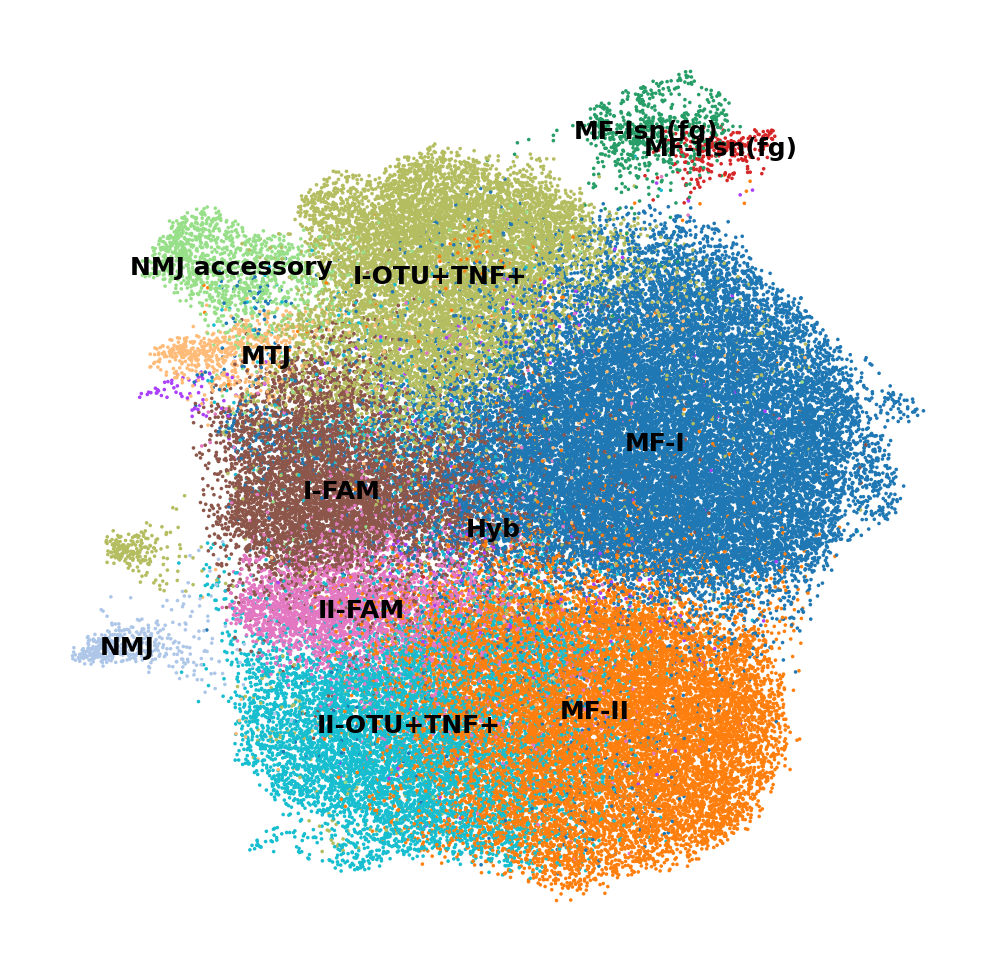

In [9]:
sc.pl.umap(adata_nc, color = ['annotation_level1'], legend_loc = "on data", legend_fontsize = 6, s = 3, 
          frameon = False, title = "", save = f"Myofiber_nuclei{today}.pdf")

/nfs/team205/vk8/mambaforge/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


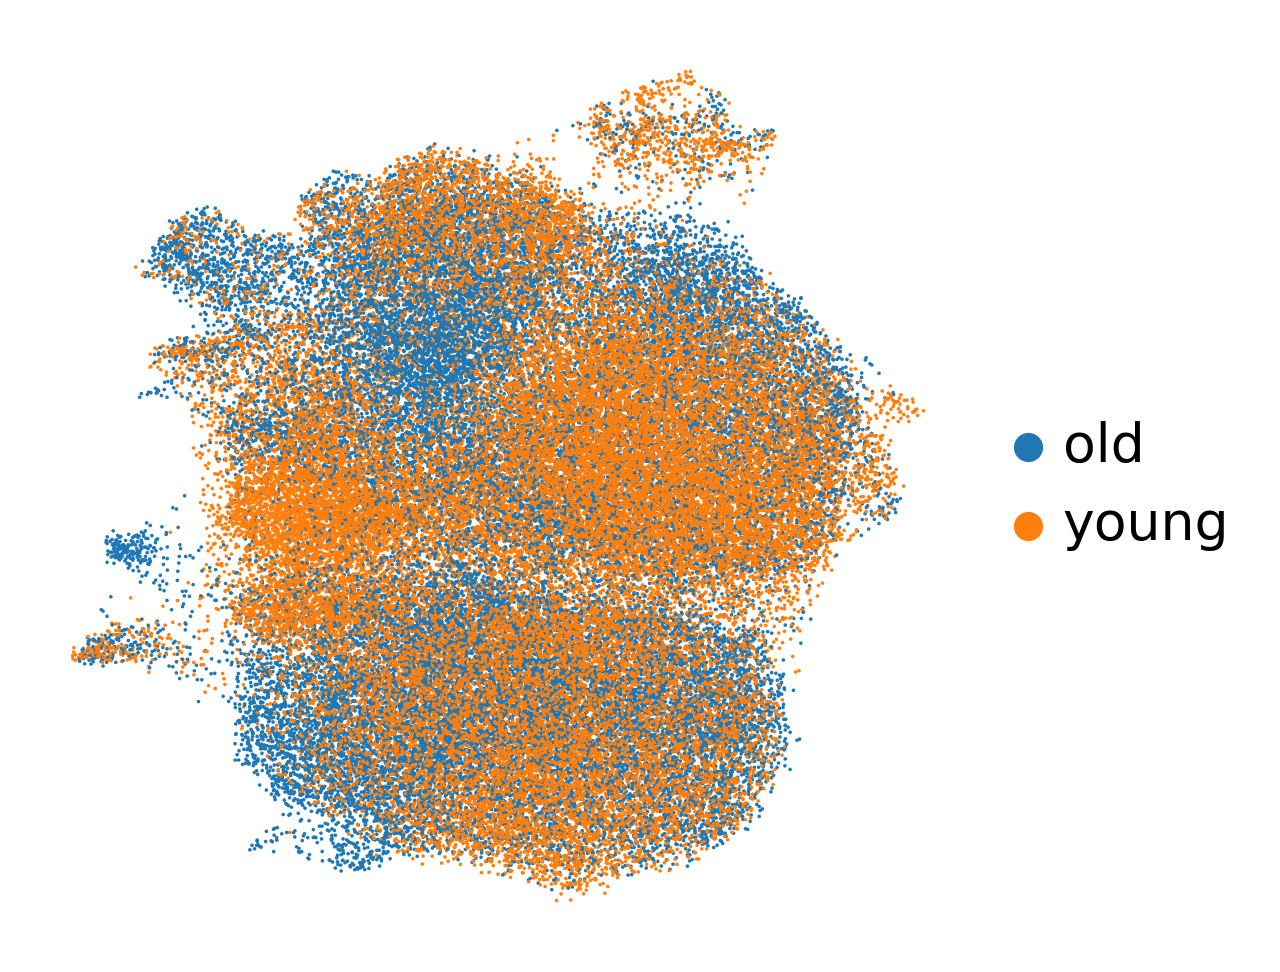

In [26]:
sc.pl.umap(adata_nc, color = ['Age_group'], s = 3, 
          frameon = False, title = "", save = f"Myofiber_nuclei_age{today}.pdf")

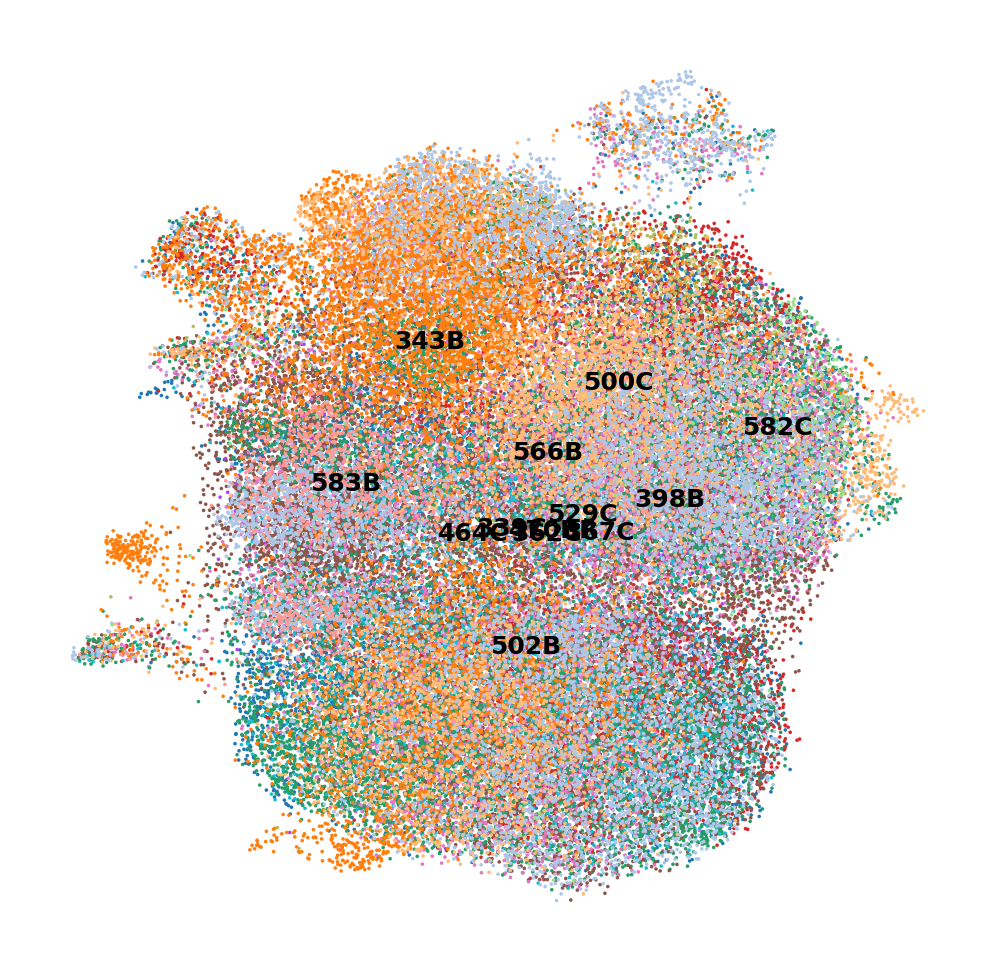

In [31]:
sc.pl.umap(adata_nc, color = ['DonorID'], legend_loc = "on data", legend_fontsize = 6, s = 3, 
          frameon = False, title = "", save = f"Myofiber_nuclei2Donor_{today}.pdf")

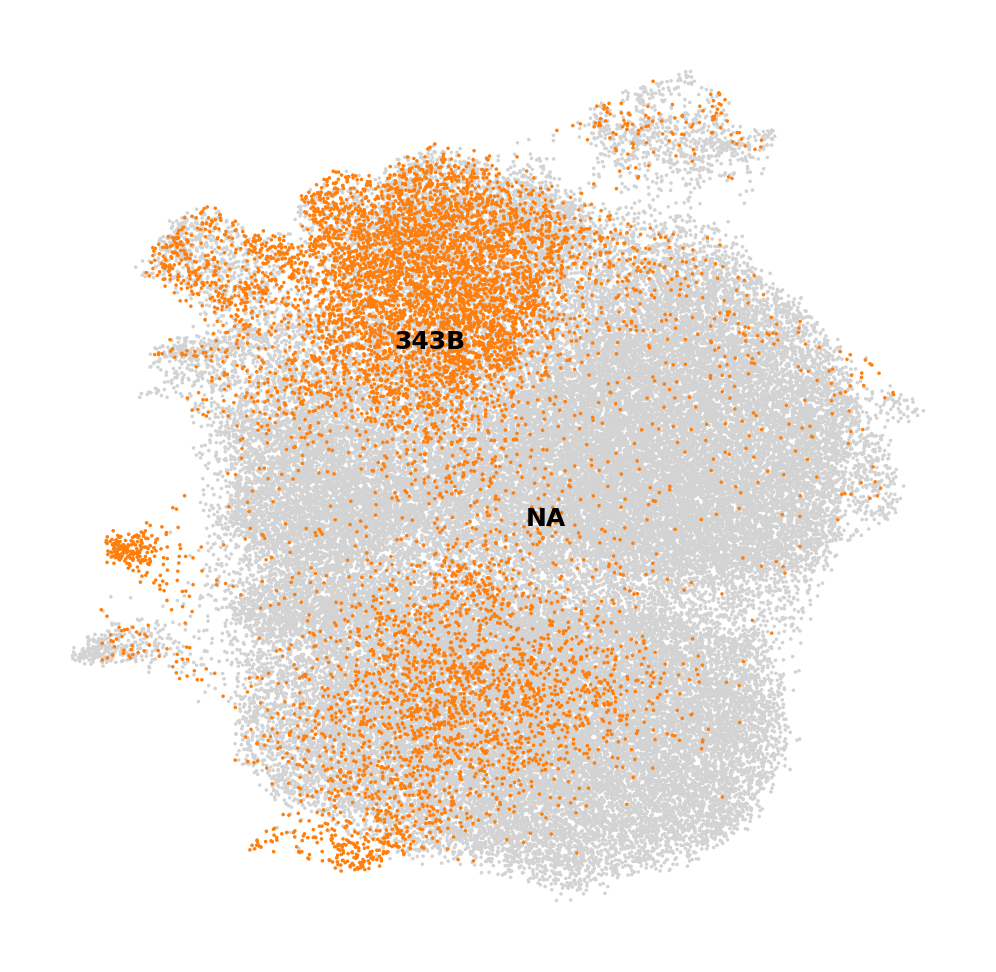

In [32]:
sc.pl.umap(adata_nc, color = ['DonorID'], groups = ['343B'], legend_loc = "on data", legend_fontsize = 6, s = 3, 
          frameon = False, title = "")

### 2. Plot markers genes for main nuclei populations (Figure 3f and 3h)

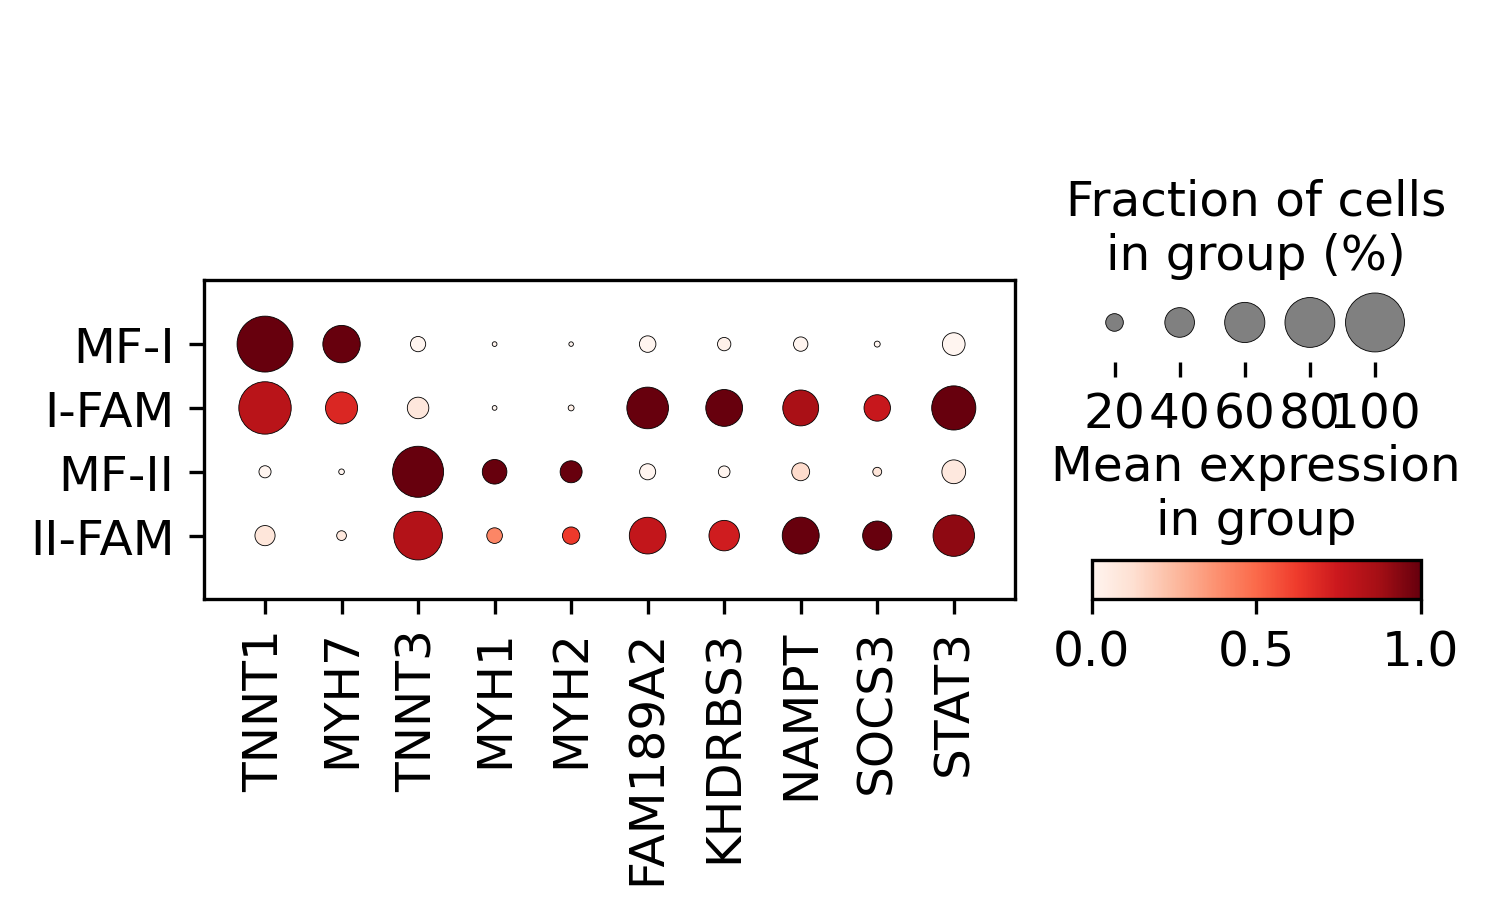

In [12]:
sc.pl.dotplot(adata_nc[adata_nc.obs['annotation_level1'].isin(['MF-I', 'I-FAM','MF-II', 'II-FAM'])], 
              groupby = 'annotation_level1', var_names = ['TNNT1', 'MYH7', 'TNNT3', 'MYH1', 'MYH2',
               'FAM189A2', 'KHDRBS3','NAMPT', 'SOCS3', 'STAT3'], standard_scale = "var",
             categories_order = ['MF-I', 'I-FAM','MF-II', 'II-FAM'], save = "FAM_mrkrs_plot1.pdf")


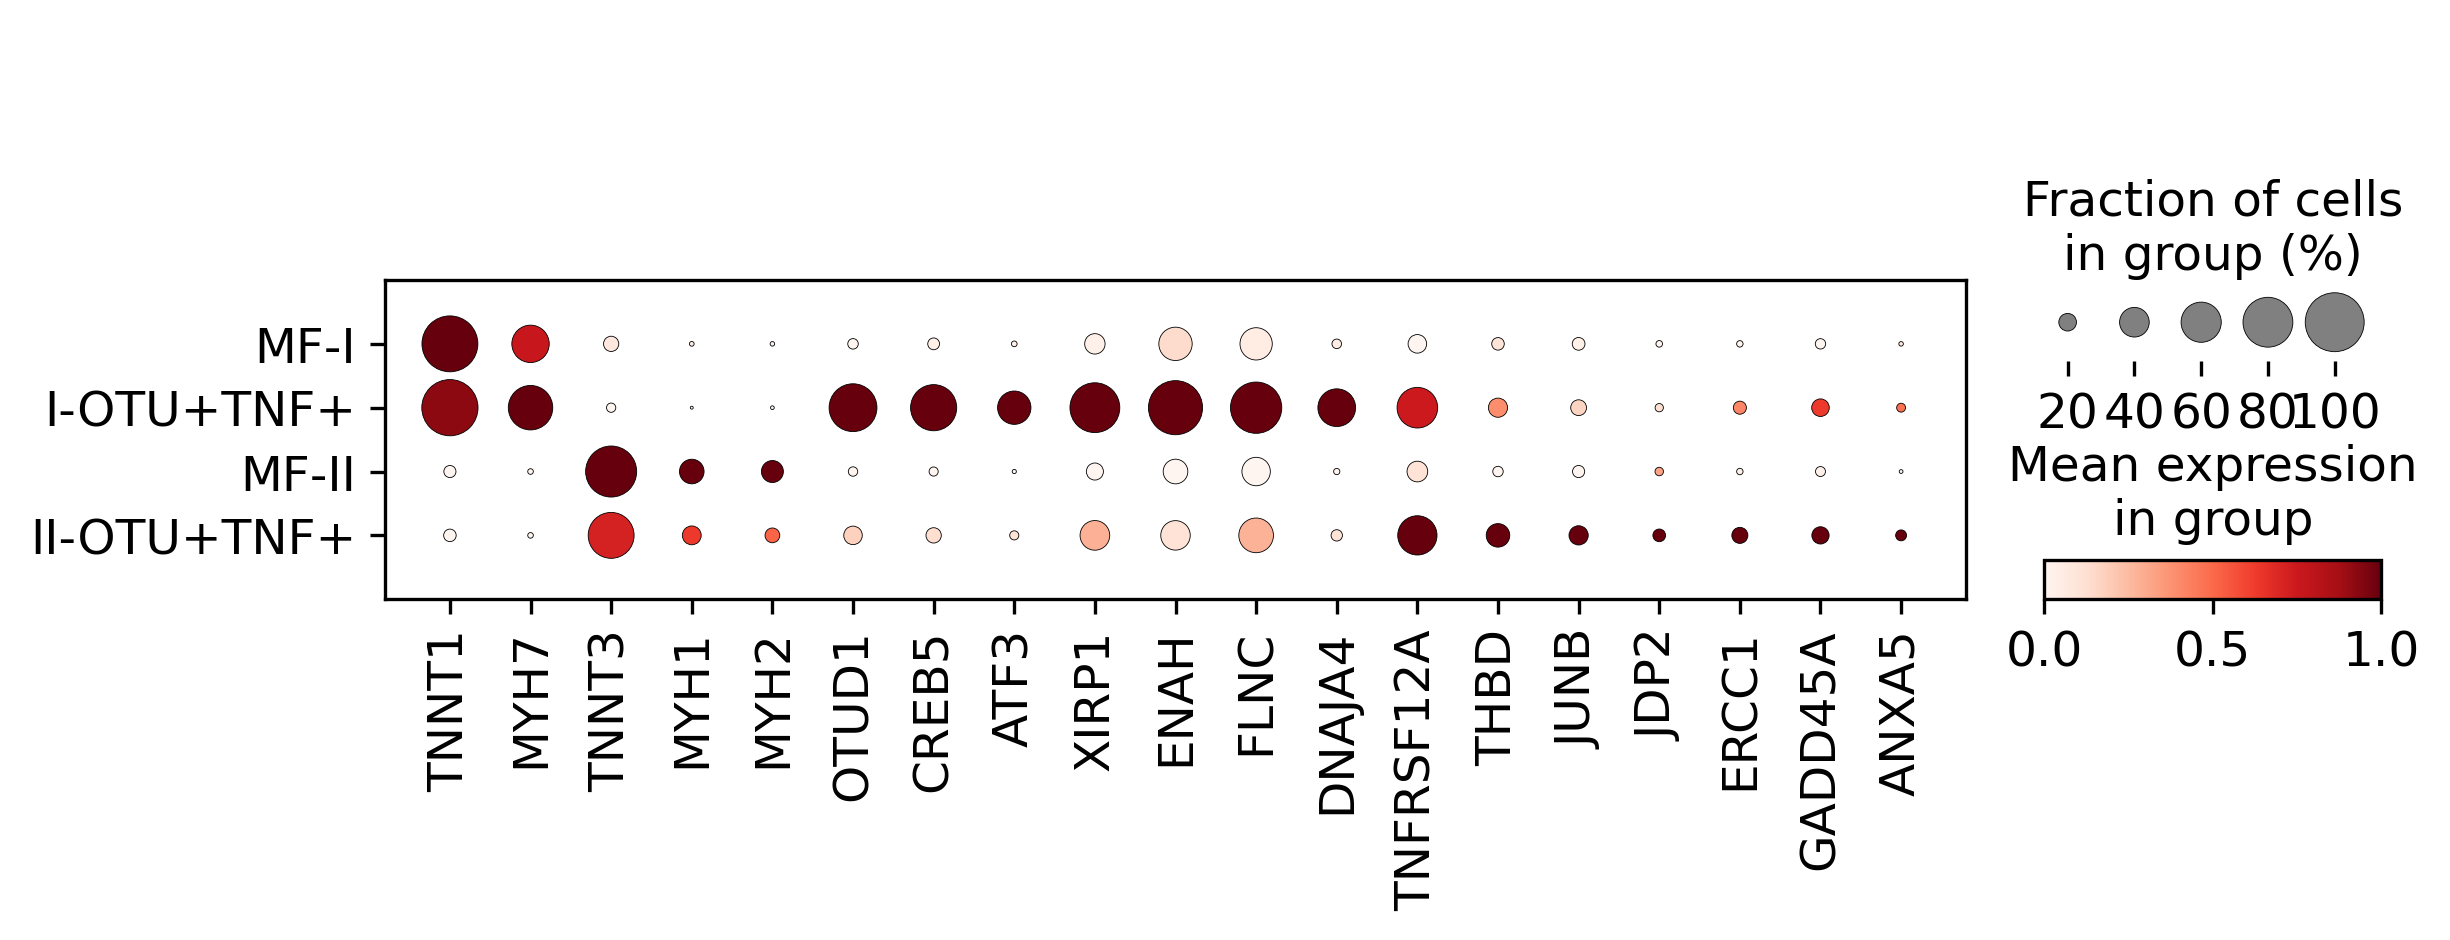

In [37]:
sc.pl.dotplot(adata_nc[adata_nc.obs['annotation_level1'].isin(['MF-I', 'I-OTU+TNF+', 'MF-II','II-OTU+TNF+',])], groupby = 'annotation_level1', var_names = ['TNNT1', 'MYH7', 'TNNT3', 'MYH1', 'MYH2',
                                                                     'OTUD1','CREB5', 'ATF3', 'XIRP1','ENAH', 'FLNC', 'DNAJA4',
                                                            'TNFRSF12A', 'THBD','JUNB', 'JDP2', 'ERCC1','GADD45A','ANXA5'], 
              categories_order = ['MF-I', 'I-OTU+TNF+', 'MF-II','II-OTU+TNF+',], standard_scale = "var",
              save = "OTU-TNF_mrkrs_plot1.pdf")

### 3. Plot markers genes for NMJ accessory populations

In [9]:
nmj_acc_mrkrs_rev = {'NMJ:synapse apparatus': ['MUSK', 'PLCB4', 'ACHE', 'LRP4', 'CHRNE', 'ETV4', 'ETV5', 'SOX11'],
                     'NMJ acc.:synapse formation/organisation':
                 ['SORBS2','STYK1','STK38L', 'DGKB','APBB2','DOCK10', 'BMPR1B','GRIA2','IL1RAP','PTPRD',
                  'BDNF','EFNA5', 'NRXN3','CDH2', 'ONECUT2', 'PIGR']} 

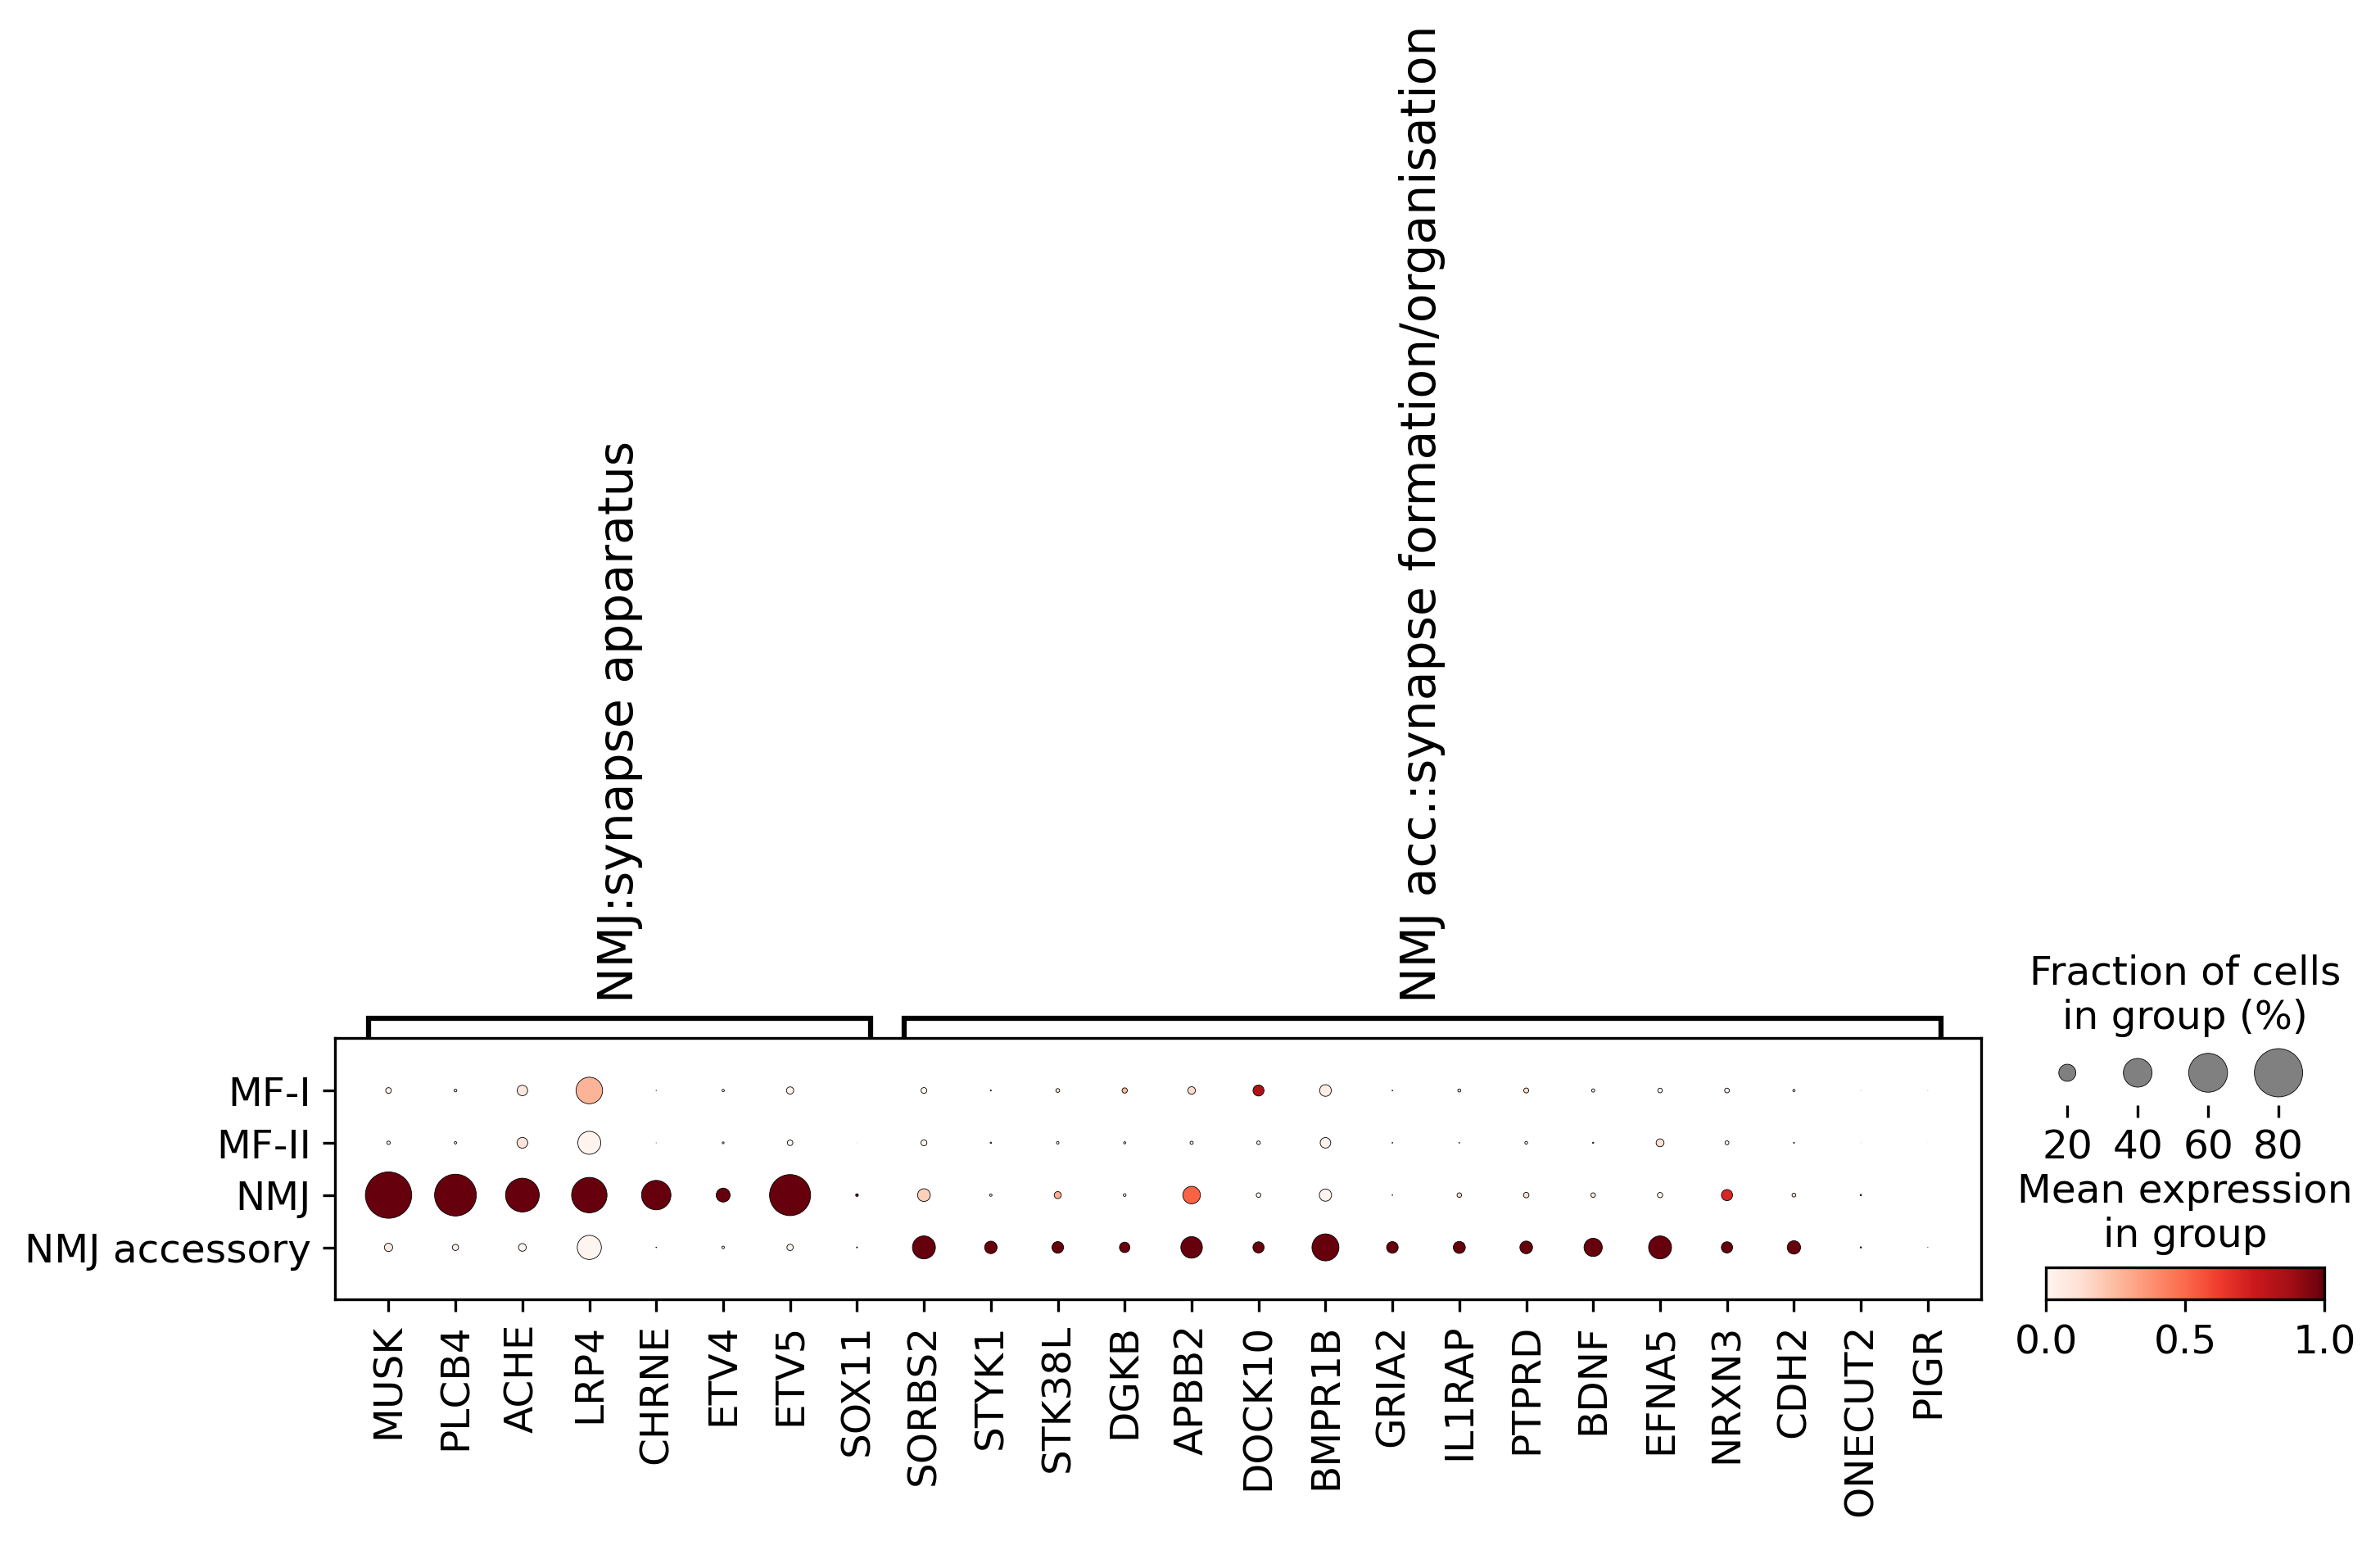

In [10]:
sc.pl.dotplot(adata_nc[adata_nc.obs['annotation_level1'].isin(['MF-I', 'MF-II', 'NMJ','NMJ accessory',])], groupby = 'annotation_level1', 
              var_names = nmj_acc_mrkrs_rev,
              categories_order = ['MF-I', 'MF-II', 'NMJ','NMJ accessory'], 
              standard_scale = "var",
              save = "NMJaccessory_mrkrs_rev.pdf")

### Extended Data Fig. 5d

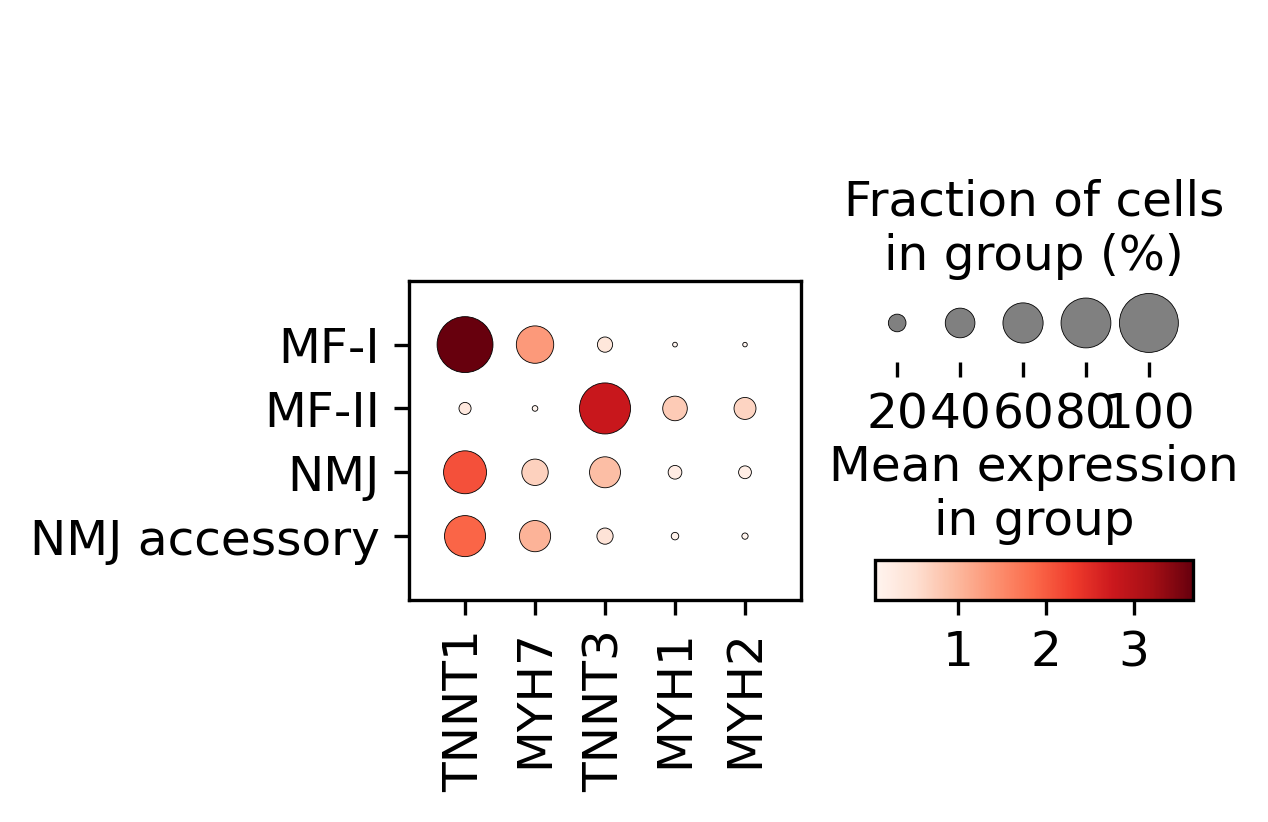

In [28]:
sc.pl.dotplot(adata_nc[adata_nc.obs['annotation_level1'].isin(['MF-I', 'MF-II', 'NMJ','NMJ accessory',])], groupby = 'annotation_level1', 
              var_names = ['TNNT1', 'MYH7', 'TNNT3', 'MYH1', 'MYH2'],
              categories_order = ['MF-I', 'MF-II', 'NMJ','NMJ accessory'], 
              save = "Fast_vs_slow_NMJacc.pdf")

In [73]:
adata_nc.obs['Age_group'] = adata_nc.obs['Age_group'].cat.reorder_categories(['young', 'old'])

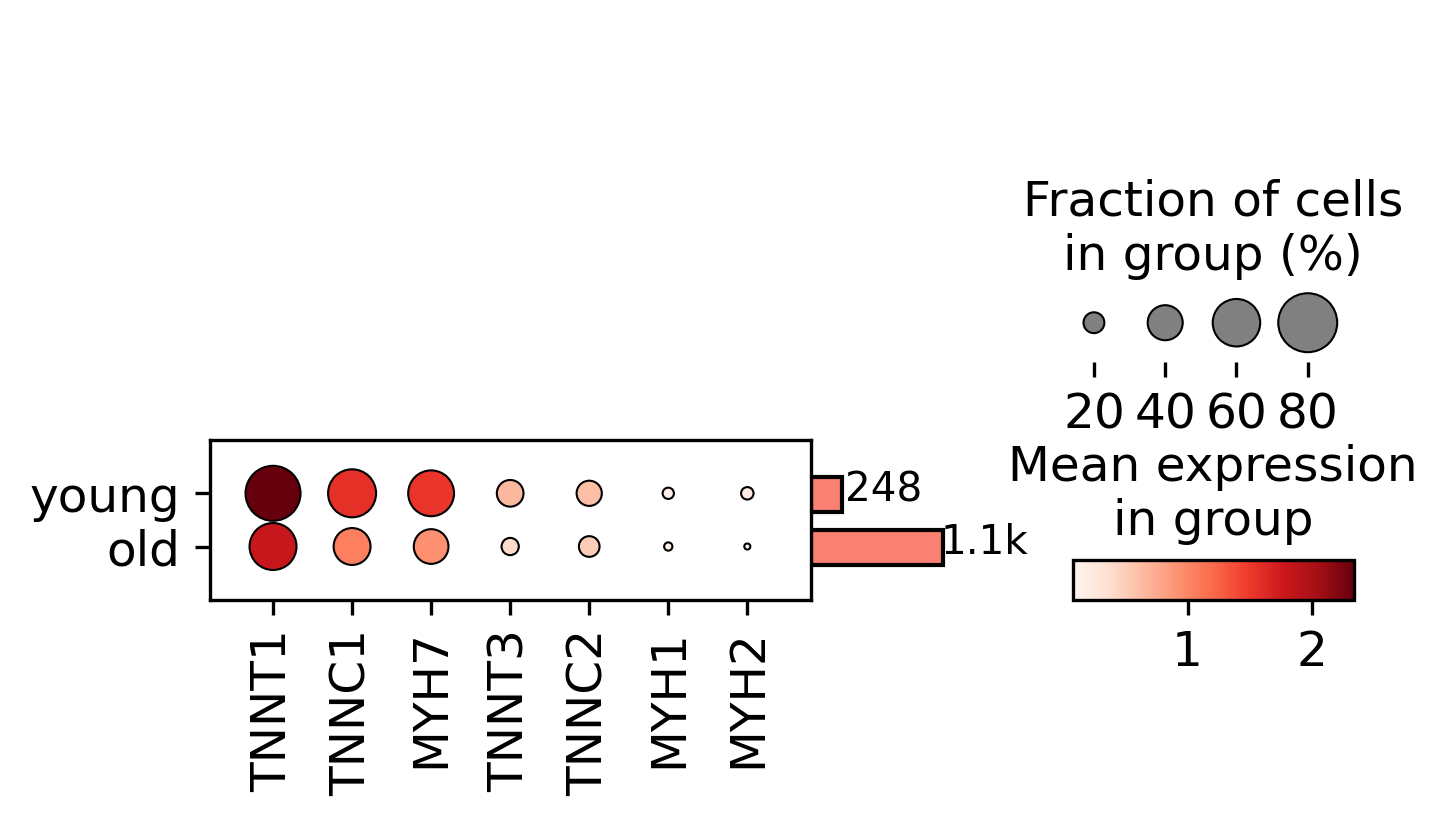

In [110]:
dp_nmj_acc = sc.pl.dotplot(adata_nc[adata_nc.obs['annotation_level1']=='NMJ accessory',], groupby = 'Age_group', 
              var_names = ['TNNT1','TNNC1', 'MYH7', 'TNNT3','TNNC2', 'MYH1', 'MYH2'],
             # categories_order = ['MF-I', 'MF-II', 'NMJ','NMJ accessory'], 
             return_fig=True)

dp_nmj_acc = dp_nmj_acc.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap = "Reds")
dp_nmj_acc.savefig(f"{figures}/NMJ_acc.slow2fast.pdf")

### 4. Perform GO enrichments on FAM+, OTU+TNF+ and NMJ accessory nuclei populations (Extended Data Fig. 4g)

In [15]:
vae_mfnuc = scvi.model.SCVI.load(f"{model_folder}/ICM_myonuclei_data_scvi1_2023-05-07")

INFO     Using data from adata.X                                                             


/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 74855 cells, 10003 vars, 22       
         batches, 1 labels, and 0 proteins. Also registered 3 extra categorical covariates   
         and 1 extra continuous covariates.                                                  


In [16]:
vae_mfnuc.adata.obs['annotation_level1'] = adata_nc.obs.reindex(vae_mfnuc.adata.obs_names)['annotation_level1']

In [17]:
vae_mfnuc.adata.obs['annotation_level1'].cat.categories

Index(['MF-I', 'MF-II', 'MF-Isn(fg)', 'MF-IIsn(fg)', 'Hyb', 'I-FAM', 'II-FAM',
       'I-OTU+TNF+', 'II-OTU+TNF+', 'NMJ', 'MTJ', 'NMJ accessory'],
      dtype='object')

In [18]:
def scvi_markers_compare(vae, cluster, group_1, group_2):
    results = {}
    de_df = vae.differential_expression(
    groupby=cluster, group1 = group_1, group2 = group_2)
    de_df['cluster'] = de_df['group1']
    de_df = de_df.loc[(de_df.lfc_mean>1)&(de_df.bayes_factor>2) &(de_df.non_zeros_proportion1>0.1)]
    markers = de_df.index.tolist()
    results['de_df'] = de_df
    results['markers'] = markers
    #print(results)
    return(results)

In [19]:
de_groups_mfnuc = [('I-FAM', 'MF-I'), ('II-FAM', 'MF-II'), ('I-OTU+TNF+', 'MF-I'),\
 ('II-OTU+TNF+', 'MF-II'), ('NMJ accessory', None), ('NMJ', None), \
             ('MTJ', None)]

In [20]:
##bayes factor > 2.5
de_mrks_dict2 = {}
de_df_list2 = []
for i in de_groups_mfnuc:
    df2 = scvi_markers_compare (vae_mfnuc, cluster = 'annotation_level1', group_1=i[0], group_2=i[1])
    de_mrks_dict2[i[0]] = df2['markers']
    de_df_list2.append(df2['de_df'])  

DE...: 100%|██████████| 1/1 [00:08<00:00,  8.05s/it]


In [46]:
tables

'/nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/tables'

In [21]:
vae_mrks_dt_mfnuc2 = pd.concat(de_df_list2)
vae_mrks_dt_mfnuc2.to_csv(f"/{tables}/Supplementary_table5_p2_myofiber_markers_scvi_comparison_v2_reanalysis.csv")

In [22]:
myofiber_clust_enrich_df = sc.queries.enrich(de_mrks_dict2,gprofiler_kwargs={'sources': ['GO:BP', 'REAC', 'KEGG'], 'no_evidences': False, 'all_results': True}, org="hsapiens")
myofiber_clust_enrich_df.significant = myofiber_clust_enrich_df.p_value<0.1
myofiber_clust_enrich_df.significant.sum()

821

In [23]:
myofiber_clust_enrich_df['f'] = 2*myofiber_clust_enrich_df.precision*myofiber_clust_enrich_df.recall / \
(myofiber_clust_enrich_df.precision+myofiber_clust_enrich_df.recall)

myofiber_clust_enrich_df['neglogfdr'] = -np.log10(myofiber_clust_enrich_df.p_value)

In [30]:
myofiber_clust_enrich_df.to_csv(f"/{tables}/Myofiber_nuclei_GO_enrichment_all_v2_reanalysis.csv", index = False)

In [6]:
myofiber_clust_enrich_df = pd.read_csv(f"/{tables}/Myofiber_nuclei_GO_enrichment_all_v2_reanalysis.csv")

In [7]:
myofiber_clust_enrich_df

source              native   
0       REAC   REAC:R-HSA-156902  \
1       REAC   REAC:R-HSA-156842   
2       REAC   REAC:R-HSA-192823   
3       REAC  REAC:R-HSA-2408557   
4       REAC    REAC:R-HSA-72764   
...      ...                 ...   
27146  GO:BP          GO:0016567   
27147  GO:BP          GO:0016525   
27148  GO:BP          GO:0016485   
27149  GO:BP          GO:0017015   
27150   REAC        REAC:0000000   

                                                    name        p_value   
0                               Peptide chain elongation  3.630948e-106  \
1                      Eukaryotic Translation Elongation  4.532852e-104   
2                                 Viral mRNA Translation  1.252679e-103   
3                               Selenocysteine synthesis  1.354832e-101   
4                     Eukaryotic Translation Termination  1.354832e-101   
...                                                  ...            ...   
27146                             protein ubiquitination   1.000000e+00   
27147                negative regulation of angiogenesis   1.000000e+00   
27148                                 protein processing   1.000000e+00   
27149  regulation of transforming growth factor beta ...   1.000000e+00   
27150                                 REACTOME root term   1.000000e+00   

       significant                                        description   
0             True                           Peptide chain elongation  \
1             True                  Eukaryotic Translation Elongation   
2             True                             Viral mRNA Translation   
3             True                           Selenocysteine synthesis   
4             True                 Eukaryotic Translation Termination   
...            ...                                                ...   
27146        False  "The process in which one or more ubiquitin gr...   
27147        False  "Any process that stops, prevents, or reduces ...   
27148        False  "Any protein maturation process achieved by th...   
27149        False  "Any process that modulates the frequency, rat...   
27150        False                                 REACTOME root term   

       term_size  query_size  intersection_size  effective_domain_size   
0             90         141                 65                  10790  \
1             94         141                 65                  10790   
2             90         141                 64                  10790   
3             94         141                 64                  10790   
4             94         141                 64                  10790   
...          ...         ...                ...                    ...   
27146        830         111                 10                  21110   
27147        103         111                  2                  21110   
27148        250         111                  1                  21110   
27149        140         111                  2                  21110   
27150      10790         141                141                  10790   

       precision    recall       query   
0       0.460993  0.722222         MTJ  \
1       0.460993  0.691489         MTJ   
2       0.453901  0.711111         MTJ   
3       0.453901  0.680851         MTJ   
4       0.453901  0.680851         MTJ   
...          ...       ...         ...   
27146   0.090090  0.012048  I-OTU+TNF+   
27147   0.018018  0.019417  I-OTU+TNF+   
27148   0.009009  0.004000  I-OTU+TNF+   
27149   0.018018  0.014286  I-OTU+TNF+   
27150   1.000000  0.013068         MTJ   

                                          parents   
0                           ['REAC:R-HSA-156842']  \
1                            ['REAC:R-HSA-72766']   
2                           ['REAC:R-HSA-168273']   
3                          ['REAC:R-HSA-2408522']   
4                            ['REAC:R-HSA-72766']   
...                                           ...   
27146                         

In [30]:
myofiber_clust_enrich_df.significant = myofiber_clust_enrich_df.p_value<0.05
myofiber_clust_enrich_df_sign = myofiber_clust_enrich_df.loc[(myofiber_clust_enrich_df['significant'] == True) & \
                                                            (myofiber_clust_enrich_df['term_size'] <500) & \
                                                            (myofiber_clust_enrich_df['term_size']>10) ,:].copy()

In [31]:
myofiber_clust_enrich_df_sign['query'].value_counts()

query
MTJ              126
NMJ               73
I-OTU+TNF+        56
II-FAM            21
I-FAM             16
II-OTU+TNF+       12
NMJ accessory      7
Name: count, dtype: int64

In [20]:
myofiber_clust_enrich_df_sign.to_csv(f"/{tables}/Supplementary_table5_p3_myofiber_nuclei_GO_enrichment_v2_reanalysis.csv", index = False)

myofiber_clust_enrich_df_sign = pd.read_csv(f"/{tables}/Supplementary_table5_p3_myofiber_nuclei_GO_enrichment_v2_reanalysis.csv")

In [36]:
pathways = ['response to stress', 'JAK-STAT signaling pathway', 'Cellular senescence', 'Metallothioneins bind metals',\
           'skeletal muscle tissue development', 'skeletal muscle cell differentiation', 'MAPK signaling pathway', 'cellular response to unfolded protein', 
            'protein refolding',\
           'wound healing', 'blood coagulation', 'synapse organization','regulation of synapse organization', 
            'axon development', 'activation of protein kinase activity',]

pathways2 =  ['response to stress','Interleukin-4 and Interleukin-13 signaling', 'stress-activated MAPK cascade',
             'Growth hormone receptor signaling', 'muscle organ development', 'skeletal muscle cell differentiation',
              'protein refolding', 'calcineurin-mediated signaling', 'wound healing', 'blood coagulation', 
              'synapse organization','synaptic membrane adhesion', 'axon development']

mf_path_df2 = myofiber_clust_enrich_df.loc[myofiber_clust_enrich_df['name'].isin(pathways2)].copy()
mf_path_df1 = myofiber_clust_enrich_df.loc[myofiber_clust_enrich_df['name'].isin(pathways)].copy()

mf_path_df1['query'] = mf_path_df1['query'].astype("category")
mf_path_df1['name'] = mf_path_df1['name'].astype("category")
mf_path_df1['query'] = mf_path_df1['query'].cat.reorder_categories(new_categories = ['MTJ', 'NMJ', 'NMJ accessory', 'II-OTU+TNF+',
                                                             'I-OTU+TNF+','II-FAM',\
                                                             'I-FAM']).copy()
mf_path_df1['name'] = mf_path_df1['name'].cat.reorder_categories(new_categories = pathways).copy()


mf_path_df2['query'] = mf_path_df2['query'].astype("category")
mf_path_df2['name'] = mf_path_df2['name'].astype("category")
mf_path_df2['query'] = mf_path_df2['query'].cat.reorder_categories(new_categories = ['MTJ', 'NMJ', 'NMJ accessory', 'II-OTU+TNF+',
                                                             'I-OTU+TNF+','II-FAM',\
                                                             'I-FAM']).copy()
mf_path_df2['name'] = mf_path_df2['name'].cat.reorder_categories(new_categories = pathways2).copy()

In [70]:
from plotnine import *
g = (
    ggplot(mf_path_df1, aes(x='query', y='name')) +
    geom_point(aes(size='neglogfdr', fill = 'f', color='significant'), stroke=1)+
  #  facet_wrap('common', nrow=1, scales='free_x') + 
    #scale_fill_distiller(type='div', limits=limit, name='log(odds ratio)') + 
  #  scale_fill_cmap('Blues', limits=[0, None]) +
  #  scale_color_manual(values=('#808080', '#990E1D')) + 
   # labs(size = "-log10(adj. P value)", y='Muscle disease group', x='', title='') +
  #  guides(size = guide_legend(reverse=True)) +
  #  scale_fill_cmap('Blues', limits=[0, None]) +
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='', x='', title='') +
    guides(size = guide_legend(reverse=True),  color=guide_colorbar(raster=False, nbin=100)) +
    theme_linedraw() +
    scale_size(range = (1,10)) +
    scale_y_discrete(drop=False) +
    coord_flip()+
    #scale_x_discrete(drop=False) +
    theme(
     strip_text_x = element_text(size=12, color='black', angle = 0),
     strip_text_y = element_text(size=12, color='black', angle = 0),      
     strip_background=element_rect(color='black', fill='white'),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=60, hjust=1.),
    )
)

/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/guides/guide_colorbar.py:73: PlotnineWarning: colorbar guide needs continuous scales


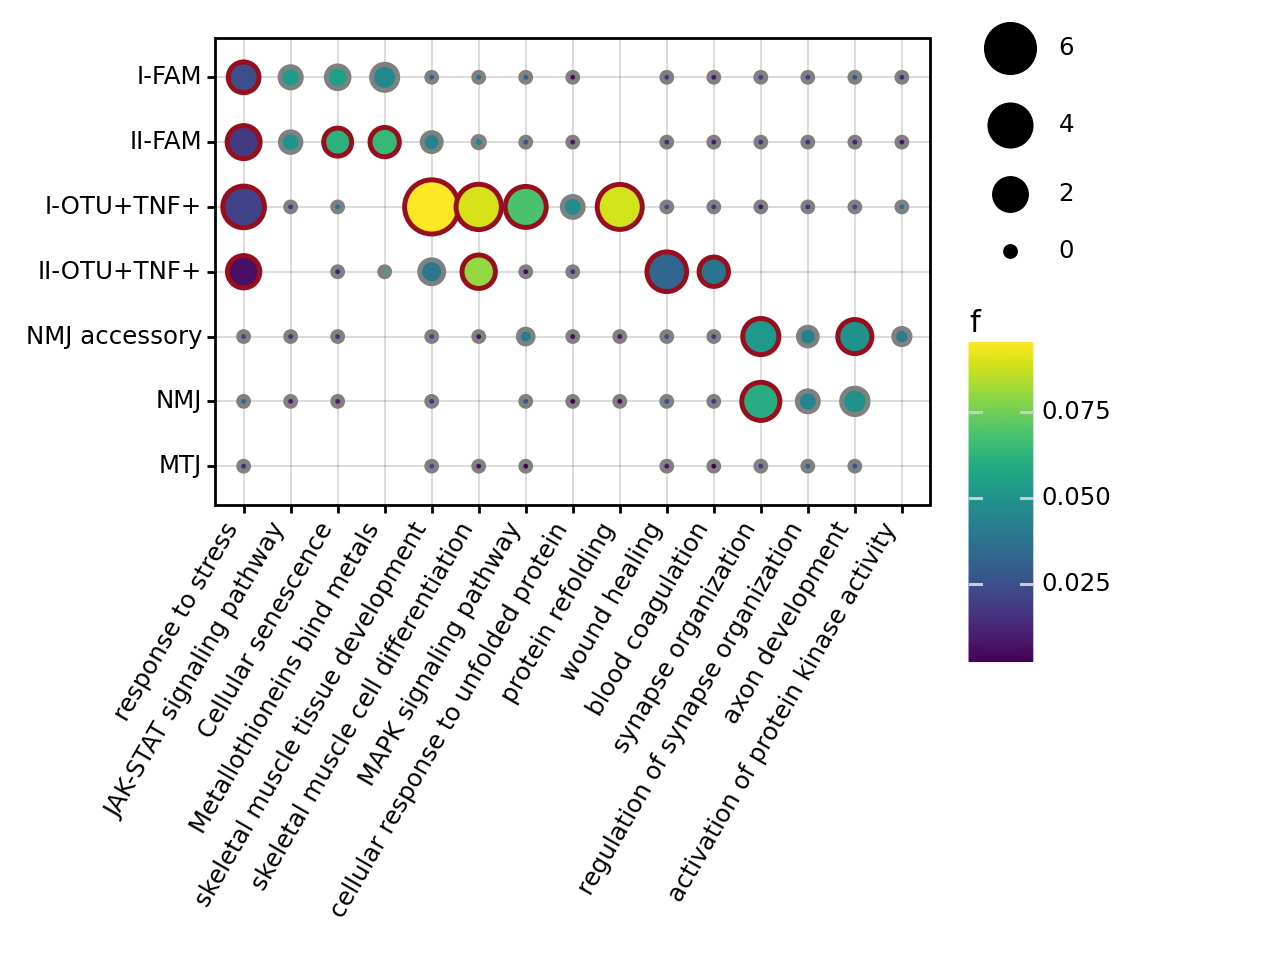

<Figure Size: (640 x 480)>

In [71]:
g

In [77]:
g.save(f"/{figures}/Figure3_enrichments_reanalysis_origin.pdf",  dpi = 300)

/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: //nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures/Figure3_enrichments_reanalysis_origin.pdf
/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/guides/guide_colorbar.py:73: PlotnineWarning: colorbar guide needs continuous scales


In [84]:
from plotnine import *
g2 = (
    ggplot(mf_path_df2, aes(x='query', y='name')) +
    geom_point(aes(size='neglogfdr', fill = 'f', color='significant'), stroke=1)+
  #  facet_wrap('common', nrow=1, scales='free_x') + 
    #scale_fill_distiller(type='div', limits=limit, name='log(odds ratio)') + 
  #  scale_fill_cmap('Blues', limits=[0, None]) +
  #  scale_color_manual(values=('#808080', '#990E1D')) + 
   # labs(size = "-log10(adj. P value)", y='Muscle disease group', x='', title='') +
  #  guides(size = guide_legend(reverse=True)) +
  #  scale_fill_cmap('Blues', limits=[0, None]) +
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='', x='', title='') +
    guides(size = guide_legend(reverse=True))+ #, color=guide_colorbar(raster=False, nbin=100)) +
    theme_linedraw() +
    scale_size(range = (1,10)) +
    scale_y_discrete(drop=False) +
    coord_flip()+
    #scale_x_discrete(drop=False) +
    theme(
     strip_text_x = element_text(size=12, color='black', angle = 0),
     strip_text_y = element_text(size=12, color='black', angle = 0),      
     strip_background=element_rect(color='black', fill='white'),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=60, hjust=1.),
    )
)

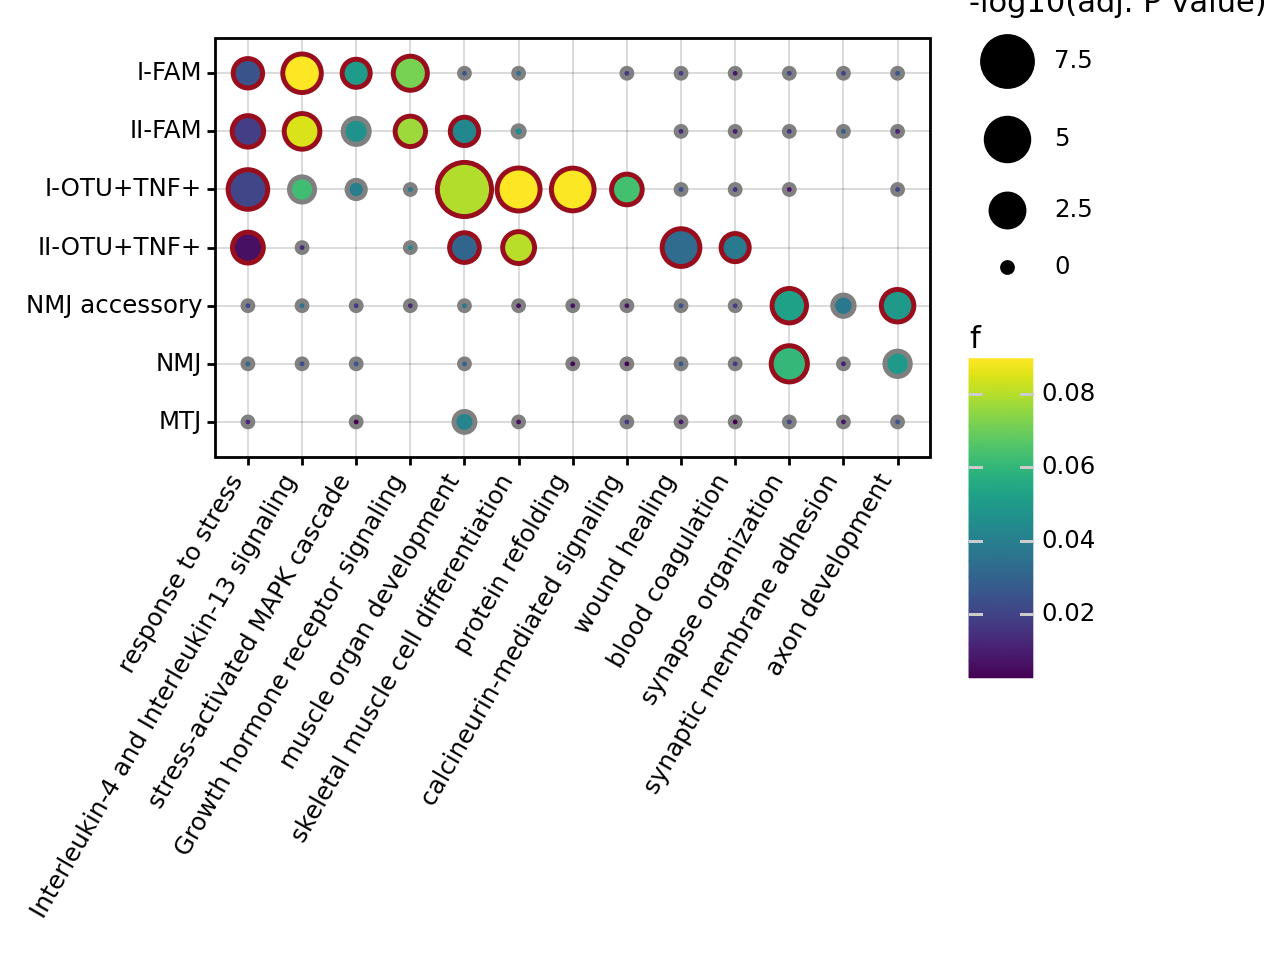

<Figure Size: (640 x 480)>

In [85]:
g2

/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/guides/guide_colorbar.py:73: PlotnineWarning: colorbar guide needs continuous scales


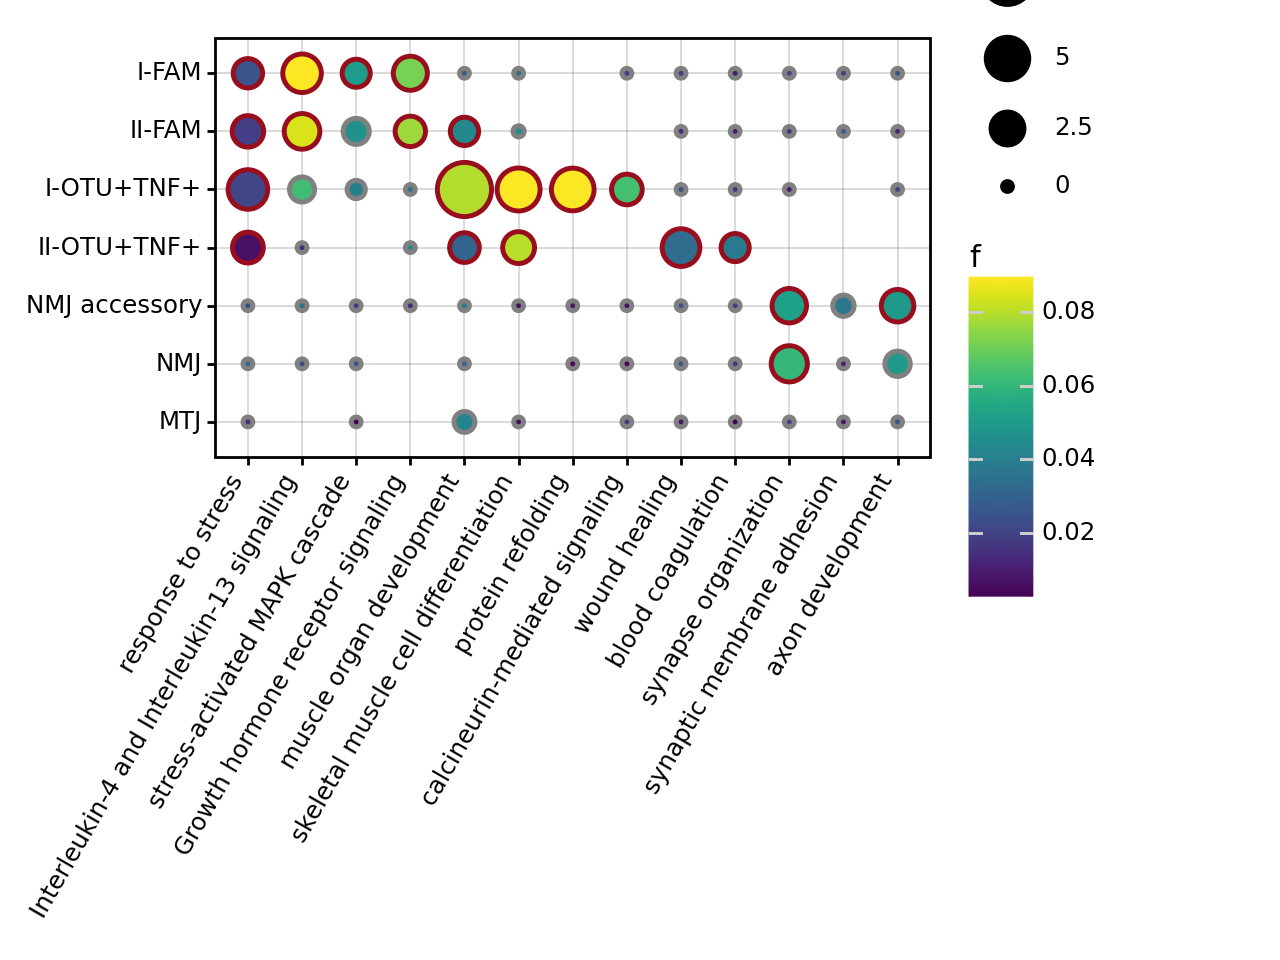

''

In [82]:
str(g2)

In [80]:
g2.save(f"/{figures}/Figure3_enrichments_reanalysis_new.pdf",dpi = 300)

/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: //nfs/team205/vk8/scripts/scvi/SKM_analyses_rev1/figures/Figure3_enrichments_reanalysis_new.pdf
/nfs/team205/vk8/mambaforge/envs/milopy-env/lib/python3.9/site-packages/plotnine/guides/guide_colorbar.py:73: PlotnineWarning: colorbar guide needs continuous scales


### 5. Plot myonuclei abundance change for major populations and NMJ populations (Extended Data Fig. 4e-f)

In [26]:
ctypes2rm = ['Hyb', 'MF-IIsn(fg)', 'MF-Isn(fg)']

In [34]:
adata_nc.obs['Age_group'].cat.reorder_categories(['young', 'old'], inplace = True)

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MF-II_young vs. MF-II_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.452e-01 U_stat=1.500e+01
MF-I_young vs. MF-I_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.452e-01 U_stat=2.000e+01
I-FAM_young vs. I-FAM_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.128e-02 U_stat=3.500e+01
II-FAM_young vs. II-FAM_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.660e-01 U_stat=2.800e+01
I-OTU+TNF+_young vs. I-OTU+TNF+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.282e-01 U_stat=2.500e+01
II-OTU+TNF+_young vs. II-OTU+TNF+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.452e-01 U_stat=1.500e+01

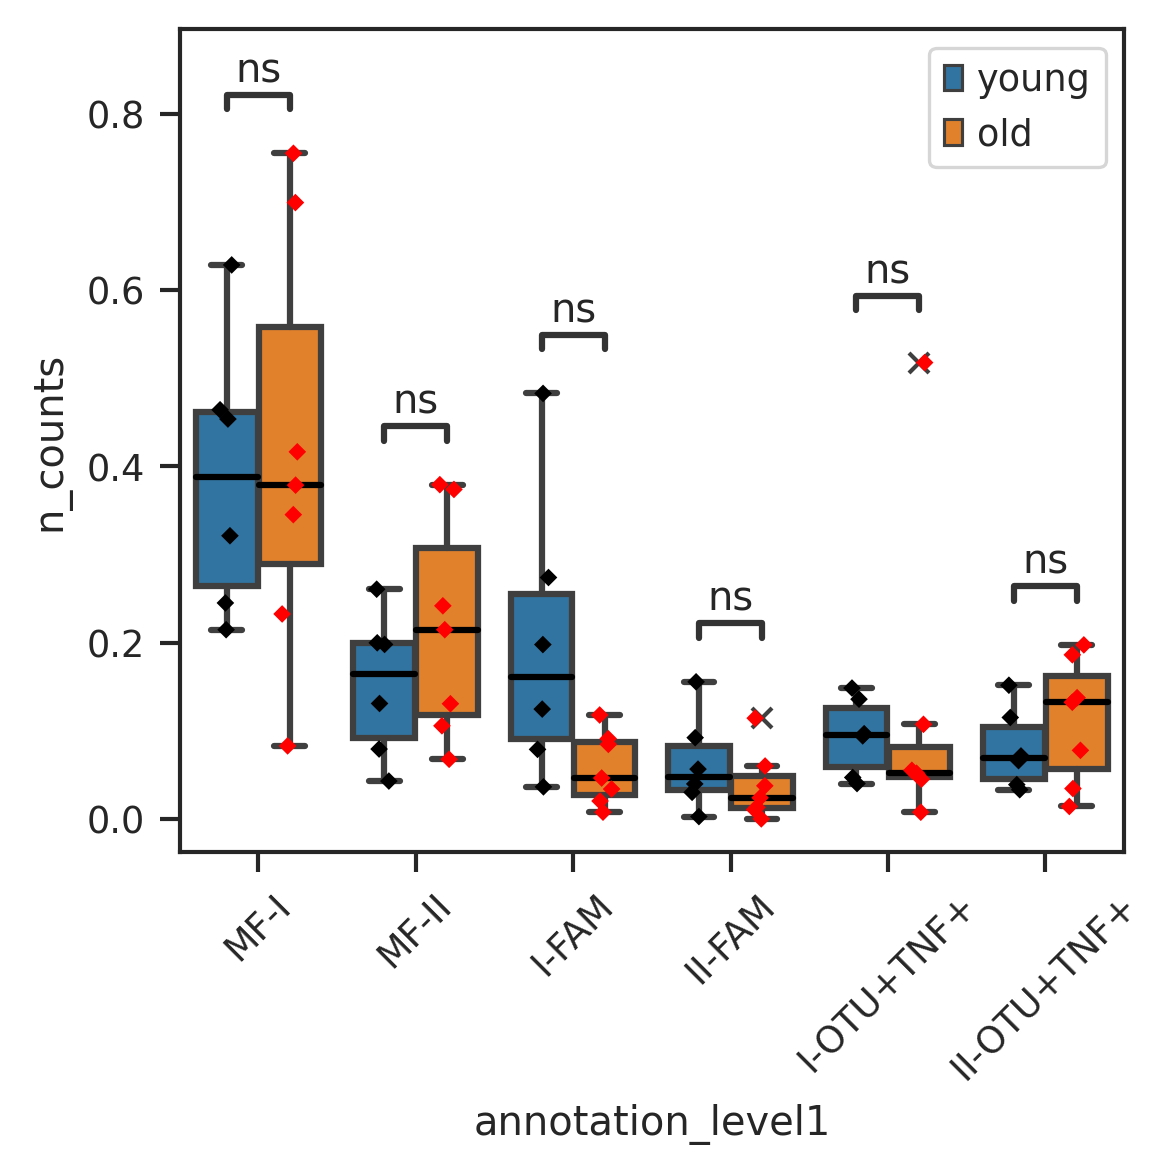

In [35]:
mf_d2ctype_major = calcul_plot_prop_box2(adata_nc, ctype_anno = 'annotation_level1', 
                      sample_anno="SampleID", donor_anno="DonorID", age_group="Age_group", 
                      filt_samples=False, subset_rm=ctypes2rm, 
                                   subset_sel=['MF-I', 'MF-II', 'I-FAM','II-FAM', 'I-OTU+TNF+','II-OTU+TNF+'], pairs=[],
                          plot_save='Myonuclei_major_change', save_dir=figures)

mf_d2ctype_major['df'].to_csv(f'{source_files}Extended_Data_Fig4e_ratios_SourceFile.csv')
mf_d2ctype_major['test_res'].to_csv(f'{source_files}Extended_Data_Fig4e_tests_SourceFile.csv')

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NMJ_young vs. NMJ_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.357e-01 U_stat=1.900e+01
MTJ_young vs. MTJ_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.452e-01 U_stat=2.000e+01
NMJ accessory_young vs. NMJ accessory_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.375e-01 U_stat=1.000e+01


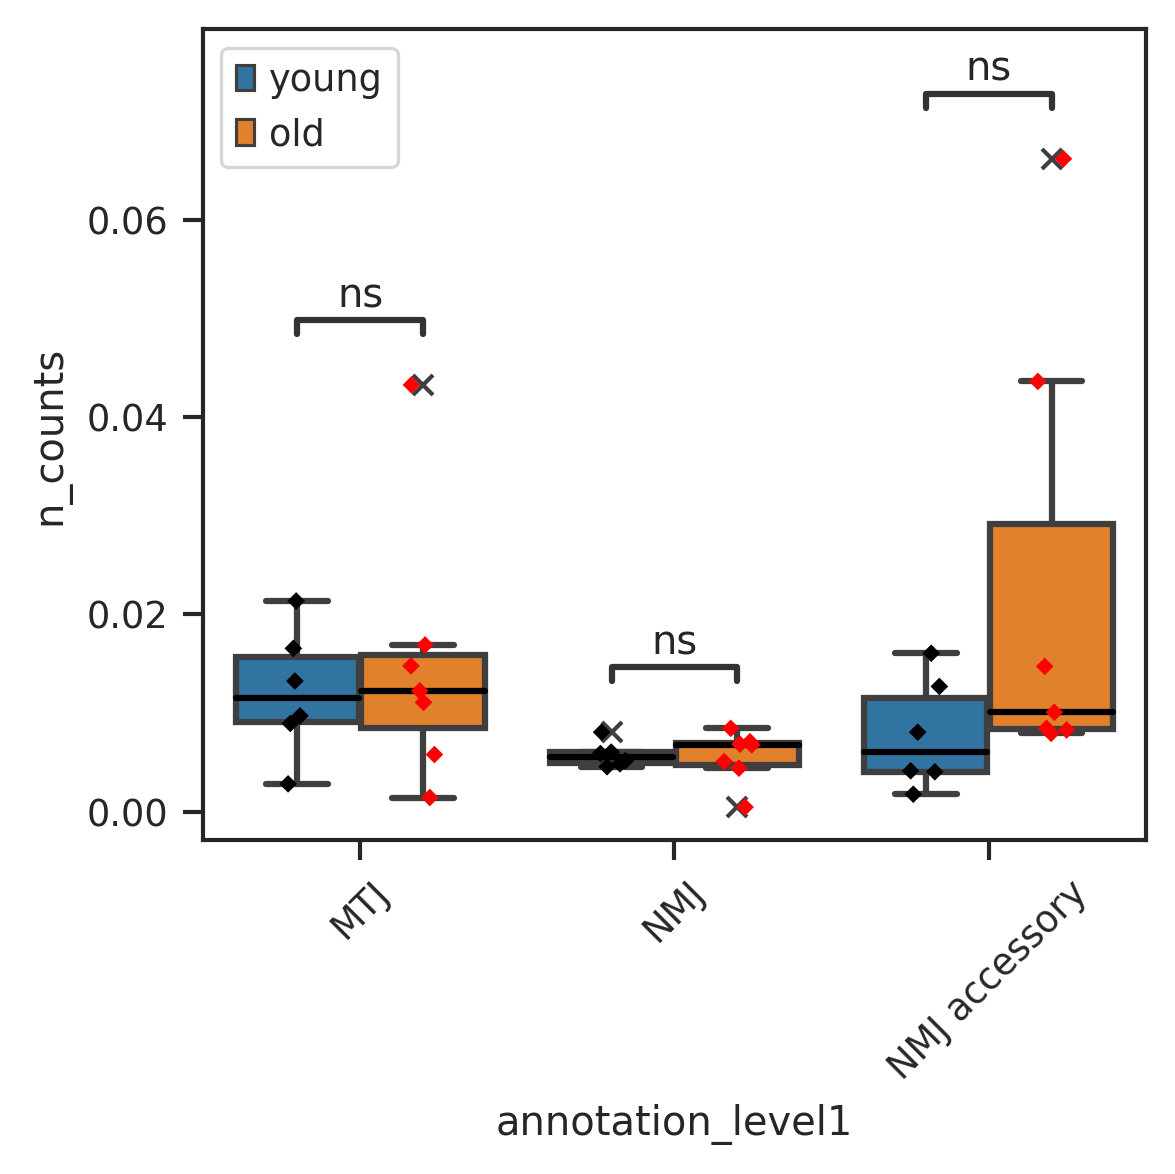

In [36]:
mf_d2ctype_nmj = calcul_plot_prop_box2(adata_nc, ctype_anno = 'annotation_level1', 
                      sample_anno="SampleID", donor_anno="DonorID", age_group="Age_group", 
                      filt_samples=False, subset_rm=ctypes2rm, 
                                   subset_sel=['MTJ', 'NMJ', 'NMJ accessory'], pairs=[],
                          plot_save='Myonuclei_nmj_change', save_dir=figures)
mf_d2ctype_nmj['df'].to_csv(f'{source_files}Extended_Data_Fig4f_ratios_SourceFile.csv')
mf_d2ctype_nmj['test_res'].to_csv(f'{source_files}Extended_Data_Fig4f_tests_SourceFile.csv')

### 8. Plot cell type distribution in Perez data (Extended Data Fig. 5b-c)

In [11]:
adata_pz = sc.read("/nfs/team205/vk8/processed_data/muscle/data_v3/SKM_nuclei_Perez2022_raw_scvi3_annot_dbrm_2024-02-27.h5ad")

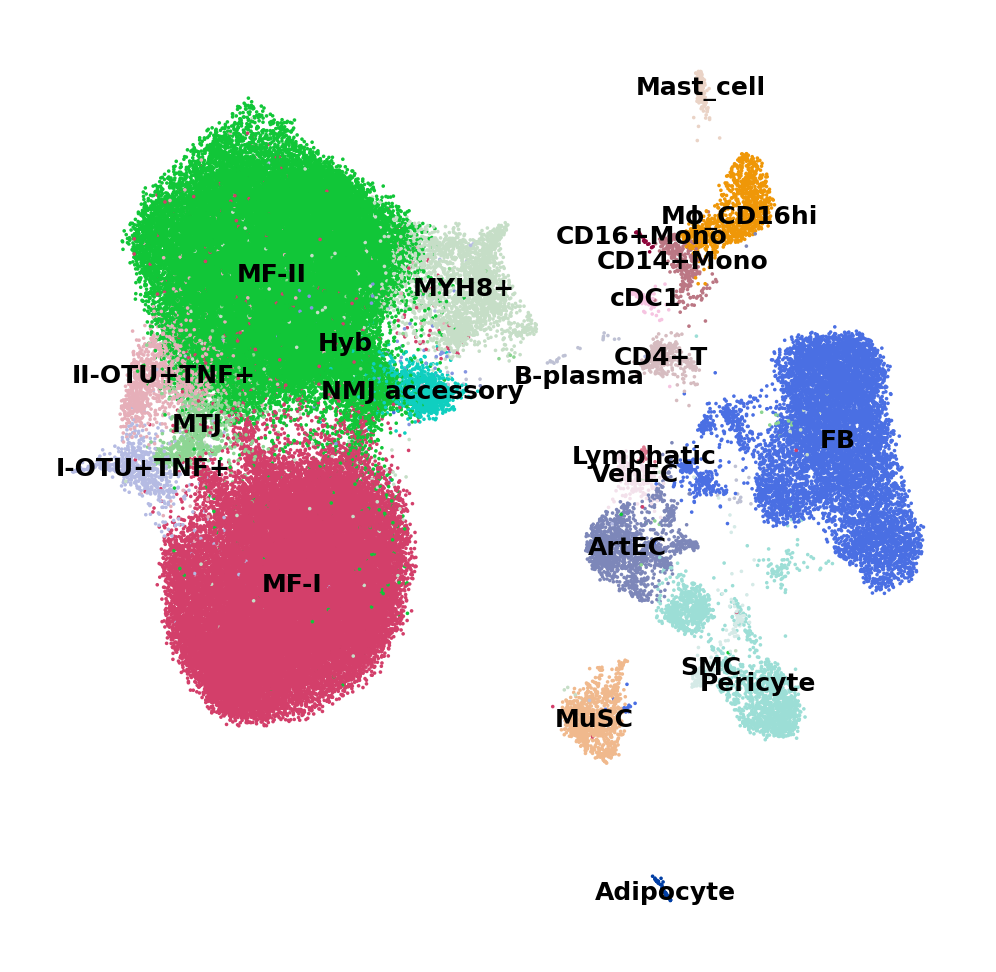

In [8]:
sc.pl.umap(adata_pz, color = ['manual_anno2'], legend_loc = "on data", legend_fontsize = 6, s = 3, 
          frameon = False, title = "", save = f"Myofiber_nuclei_perez_{today}.pdf")

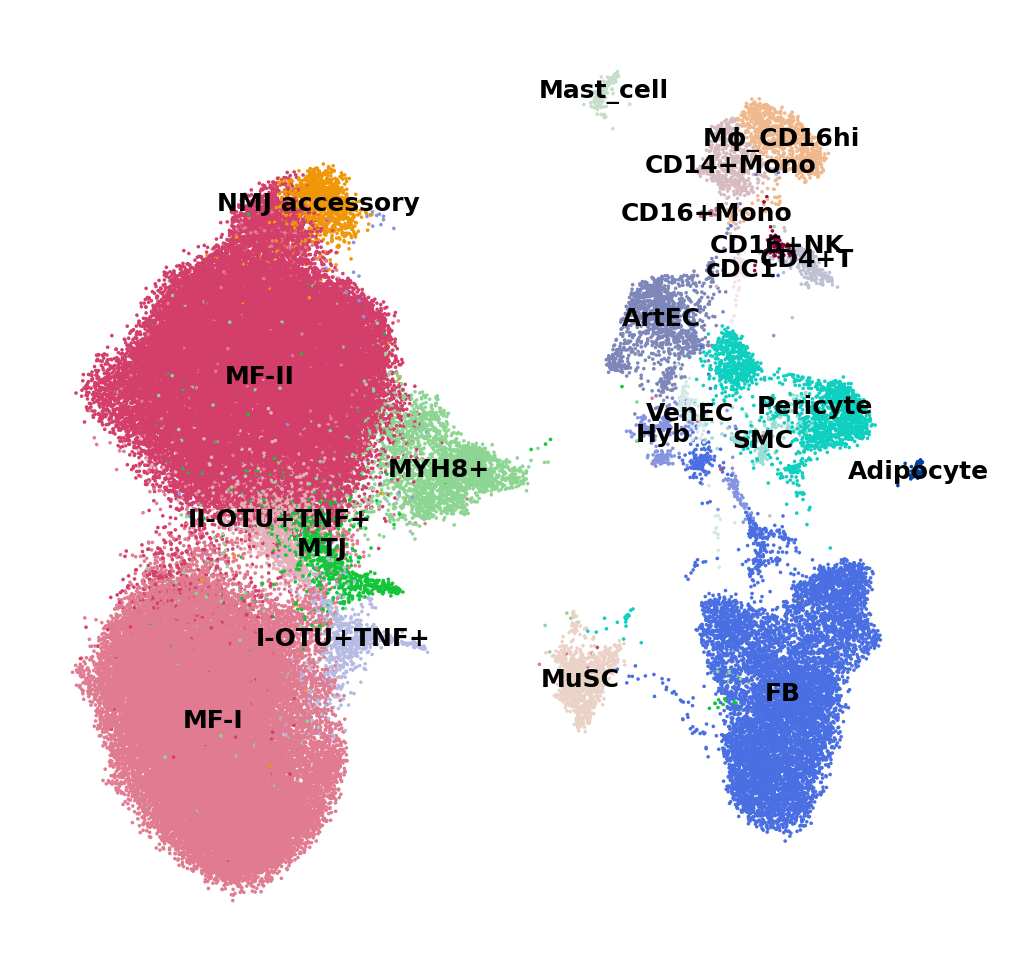

In [12]:
sc.pl.umap(adata_pz, color = ['manual_anno2'], legend_loc = "on data", legend_fontsize = 6, s = 3, 
          frameon = False, title = "", save = f"Myofiber_nuclei_perez_{today}.pdf")

In [13]:
myofiber_mrkrs_pz = ['TNNT1', 'MYH7', 'TNNT3', 'MYH1', 'MYH2', 
                     'OTUD1','CREB5', 'ATF3', 'XIRP1','ENAH', 'FLNC', 'DNAJA4', #'BDNF',  # 'NRAP', 'ANKRD1', 'XIRP2',  # OTUD1 population 
                    'TNFRSF12A', #'THBD','JUNB', 'JDP2', 'ERCC1','GADD45A','ANXA5',
                      'CDKN1A', 'ADIRF', 'MYH8', #'SAA1',  'MYH8', # MYH8 populations 'MYOD1',
                     'NCAM1', 'MAML2', 'SNX7', # MTJ
                 'SORBS2', 'EFNA5', 'BMPR1B', 'GRIA2', 'STYK1', # SORBS2 population
                   ]

In [14]:
mf_ctypes_pz = ['MF-I', 'MF-II', 'I-OTU+TNF+', 'II-OTU+TNF+', 'MYH8+', 'MTJ', 'NMJ accessory'] 

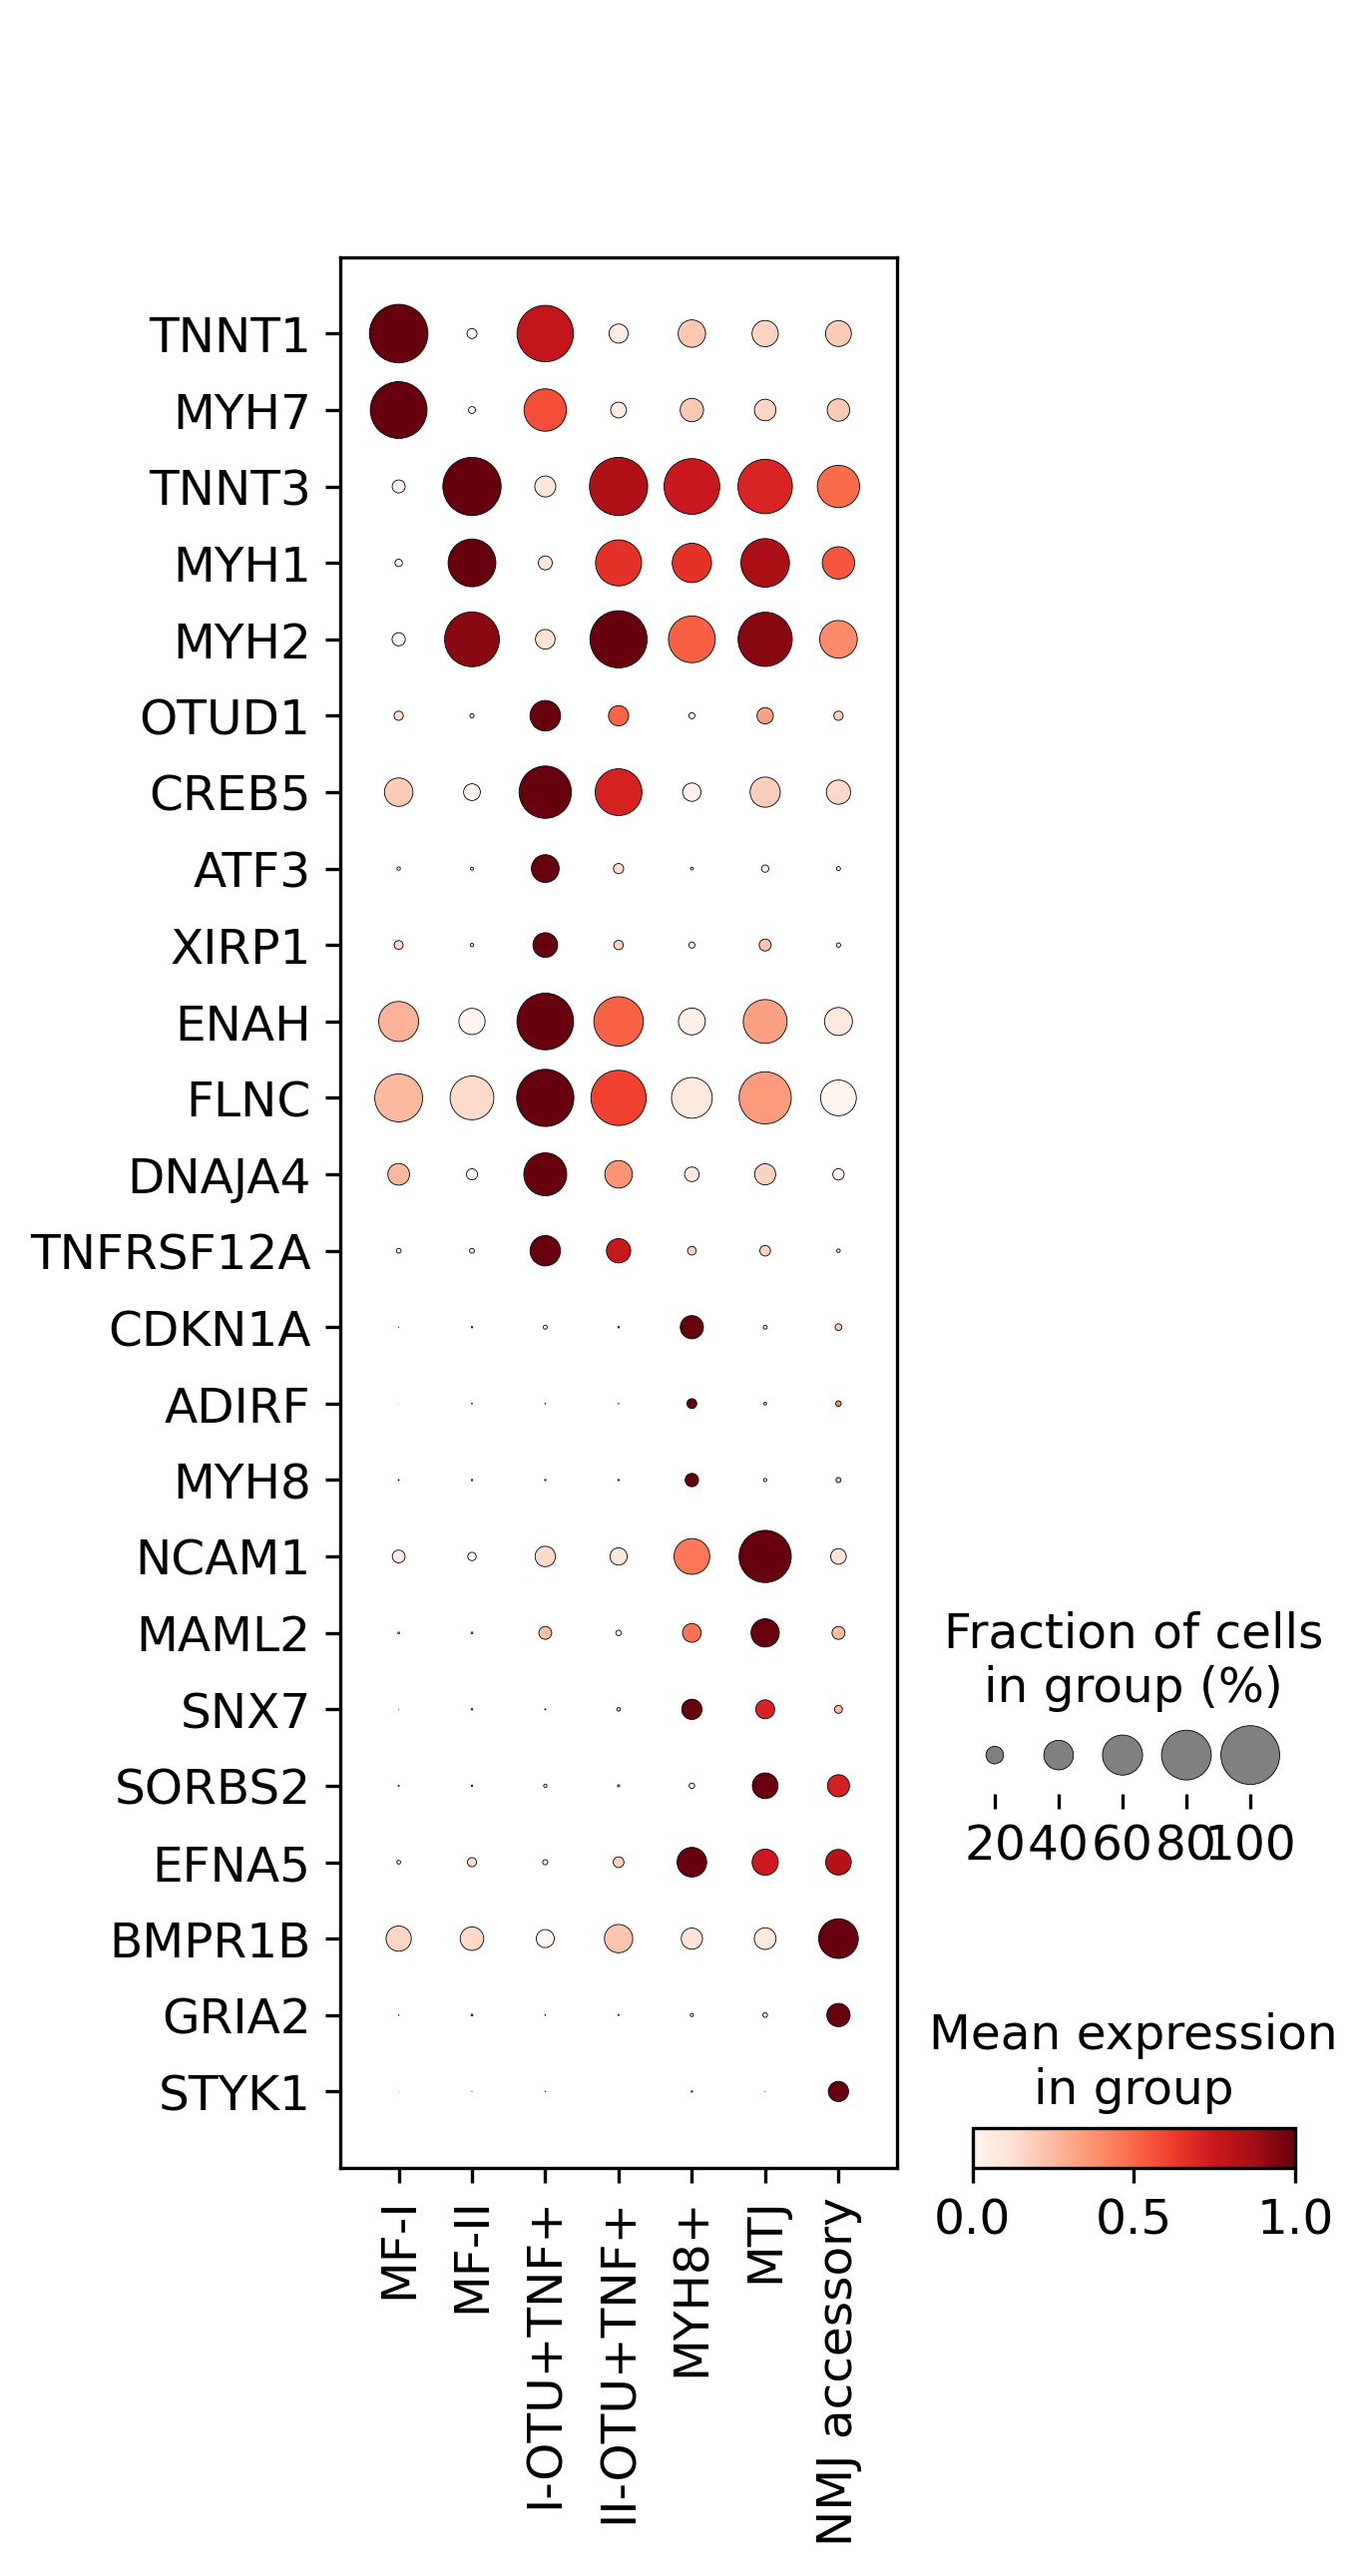

In [15]:
sc.pl.dotplot(adata_pz[adata_pz.obs['manual_anno2'].isin(mf_ctypes_pz),:], var_names = myofiber_mrkrs_pz, groupby = 'manual_anno2',
             categories_order = mf_ctypes_pz, standard_scale = "var", save = "Perez_myofiber_nuclei_v3.pdf", 
              swap_axes=True)

In [16]:
adata_pz.obs['Age_group'] = adata_pz.obs['Age_group'].cat.reorder_categories(['young', 'old'])

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MF-II_young vs. MF-II_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.215e-01 U_stat=4.900e+01
MF-I_young vs. MF-I_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.161e-01 U_stat=2.000e+01
I-OTU+TNF+_young vs. I-OTU+TNF+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.385e-01 U_stat=2.300e+01
II-OTU+TNF+_young vs. II-OTU+TNF+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.133e-01 U_stat=2.600e+01
MYH8+_young vs. MYH8+_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.939e-03 U_stat=4.000e+00
MTJ_young vs. MTJ_old: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.454e-02 U_stat=5.700e+01
NMJ a

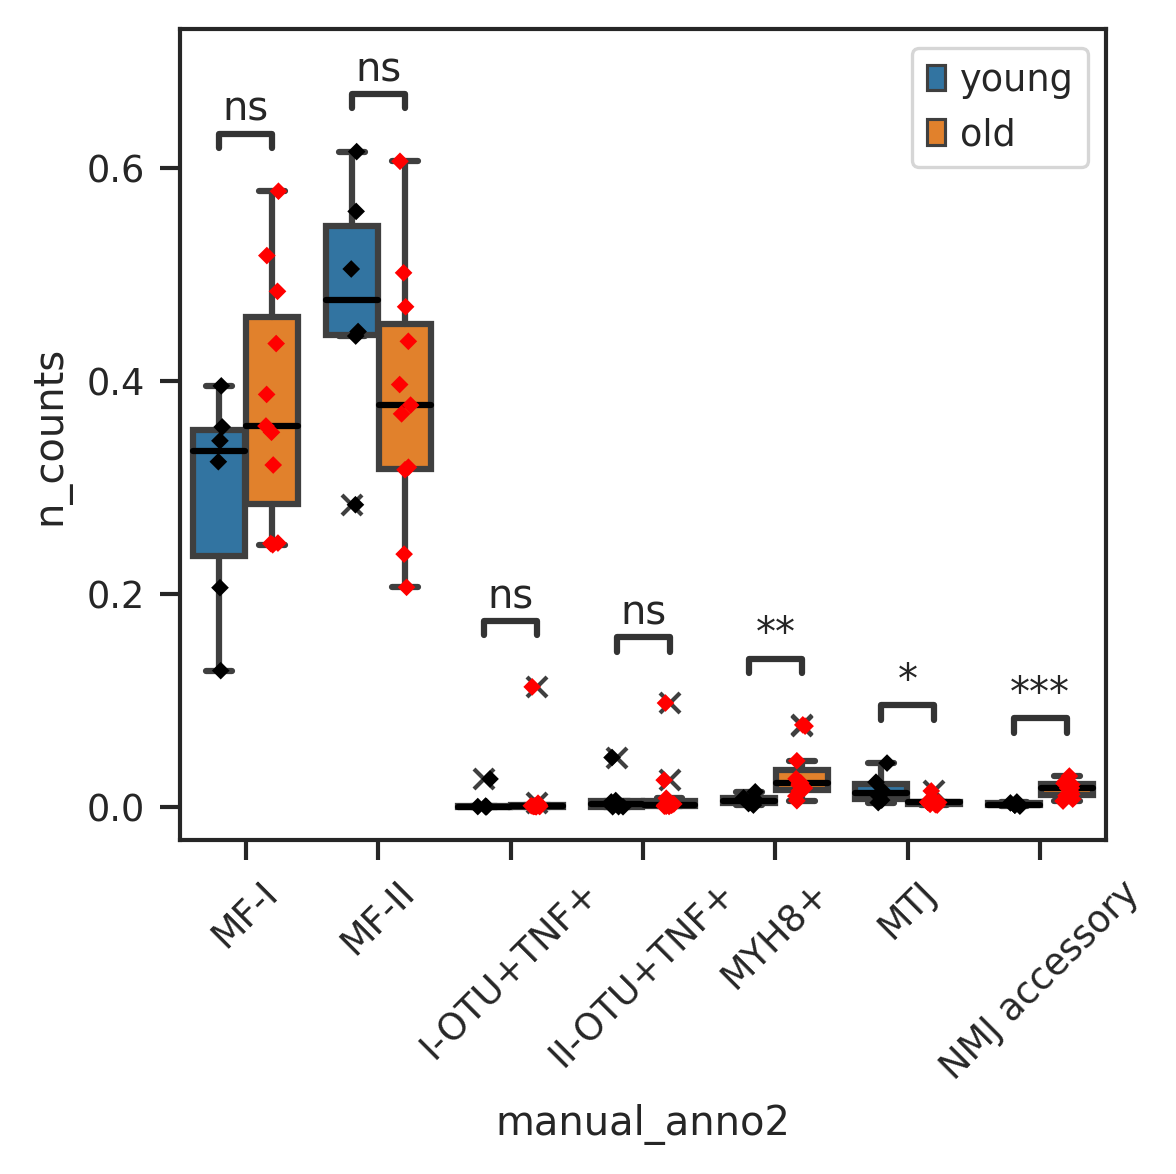

In [17]:
pz_d2ctype_dtype = calcul_plot_prop_box2(adata_pz, ctype_anno = 'manual_anno2', 
                      sample_anno="SampleID", donor_anno="Sample", age_group='Age_group', 
                      filt_samples=False, 
                                   subset_sel=['MF-I', 'MF-II', 'I-OTU+TNF+', 'II-OTU+TNF+', 'MYH8+', 'MTJ', 'NMJ accessory'] , pairs=[],
                          plot_save='Myonuclei_abund_change_pz_v3.pdf', save_dir=figures)